In [1]:
from astropy.io import fits
import pyregion
import numpy as np
import matplotlib.pyplot as plt
from astropy import units as u
from astropy import constants as cte 
import regions
from astropy.wcs import WCS
import cmasher as cm
import seaborn as sn
from discrete_gaussian_model import DiscreteGaussianModel
from astropy.nddata import Cutout2D
from astropy.coordinates import Angle
from astropy.modeling import models, fitting
from astropy.modeling.models import Const1D
from astropy.table import QTable, Table
from astropy.coordinates import SkyCoord
FITTER = fitting.LevMarLSQFitter()

/home/roberto/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
'''Primero cargamos las ubicacionees de los globules que se encuentran en la carpeta M1-67'''
regs = regions.Regions.read('m1-67-globules.reg', format="ds9")
regs = [_ for _ in regs if hasattr(_, 'center') and _.visual.get('marker') == "o"]

In [3]:
c0 = SkyCoord.from_name('wr124', cache=True)

source_table = QTable(
    [
        {"ICRS": r.center, "Isolated": r.visual.get('markeredgewidth') == 3} 
        for r in regs
    ]
)

source_table["PA"] = c0.position_angle(source_table["ICRS"]).to(u.deg)
source_table["Sep"] = source_table["ICRS"].separation(c0).to(u.arcsec)
source_table["PA"].info.format = ".2f"
source_table["Sep"].info.format = ".2f"

In [4]:
class SourceCutout:
    """Small image cut out around a given source
    """
    
    def __init__(self, pdata, hdu, size=3 * u.arcsec):
        self.center = pdata["ICRS"]
        # PA of source wrt star
        self.pa_source = pdata["PA"]
        # and PA of star wrt source
        self.pa_star = Angle(self.pa_source + 180 * u.deg).wrap_at(360 * u.deg)
        self.sep = pdata["Sep"]
        self.is_isolated = pdata["Isolated"]
        self.size = size
        self.cutout = Cutout2D(
            hdu.data, position=self.center, size=size, wcs=WCS(hdu), copy=True,
        )
        self.image = self.cutout.data
        self.wcs = self.cutout.wcs
        ny, nx = self.image.shape
        self.x, self.y = np.meshgrid(np.arange(nx), np.arange(ny))
        self.image_coords = self.wcs.pixel_to_world(self.x, self.y)
        #self.cero = self.image[self.cutout.mask][0]
        # Radius and PA of each pixel with respect to the NOMINAL center
        self.r = self.center.separation(self.image_coords)
        self.pa = self.center.position_angle(self.image_coords)
        # Default mask has max radius of half the cutout size
        self.set_mask(r_out=self.size / 2)

        self.find_bary_center()
        # Recalculate r, pa, and masks wrt the barycenter
        self.r = self.barycenter.separation(self.image_coords)
        self.pa = self.barycenter.position_angle(self.image_coords)
        self.set_mask(r_out=self.size / 2)

        # And do photometry
        self.bright_peak = np.max(self.image[self.coremask])
        '''
        intento de añadir el primer indice solamente
        '''
        self.cero = self.image[self.mask]
        # Take the 10% centile as estimate of BG value
        self.bright_bg = np.percentile(
            self.image[self.mask],
            10,
        )
        # BG-subtracted of the core region
        self.flux_core = np.sum((self.image - self.bright_bg)[self.coremask])
        # BG-subtracted part of the outer part within the mask but excluding core
        self.flux_halo = np.sum(
            (self.image - self.bright_bg)[(~self.coremask) & self.mask]
            )
        
    def __repr__(self):
        return f"SourceCutout({self.pa_source:.1f}, {self.sep:.1f})"
       
         
    def set_mask(
        self,
        r_out = 1.0 * u.arcsec,
        r_in = 0.2 * u.arcsec,
        r_core = 0.2 * u.arcsec,
        mu_min = 0.5,
    ):
        cth = np.cos((self.pa - self.pa_star))
        self.mask = (self.r <= r_out) & ((cth >= mu_min) | (self.r <= r_in))
        self.coremask = (self.r <= r_in)

    def find_bary_center(self):
        """Refine estimate of center by using flux-weighted mean
        position within the core mask
        """
        m = self.coremask

        # Original version was flux-weighted mean
        # xbary = np.average(self.x[m], weights=self.image[m])
        # ybary = np.average(self.x[m], weights=self.image[m])

        # New version is just the peak pixel
        index = np.argmax(self.image[m], axis=None)
        xbary = self.x[m][index]
        ybary = self.y[m][index]

        self.barycenter = self.wcs.pixel_to_world(xbary, ybary)

In [5]:
def fit_to_cutout(cutout):
    g0 = DiscreteGaussianModel(
        amplitude=3.0, mean=0.0, stddev=0.1, 
        bin_width=0.1, fixed={"bin_width": True},
        )
    g0.mean.fixed = True
    g0.stddev.bounds = 0.01, 0.5
    g0.amplitude.bounds = 0.01, 20.0

    g1 = DiscreteGaussianModel(
        amplitude=3.0, mean=0.5, stddev=0.2,
        bin_width=0.1, fixed={"bin_width": True},
        )
    g1.mean.bounds = 0.1, 1.5
    g1.stddev.bounds = 0.01, 1.0
    g1.amplitude.bounds = 0.01, 20.0

    c0 = Const1D(amplitude=cutout.bright_bg)
    c0.amplitude.bounds = 0.0, 1.5 * cutout.bright_bg

    model = g0 + g1 + c0
    
    
        
    '''Pruebas para quitar los puntos que son mas brillantes y nos pueden estorbar'''
    blimit = cutout.bright_peak      #encontrar el pico
    bm = cutout.image < blimit     # Es un operador que nos da solo los menores
    m = cutout.mask & bm           #Es el  operador logico 'and'
    b = cutout.image[m]
    r = cutout.r[m].arcsec
    
    #m = cutout.mask
    #r = cutout.r[m].arcsec
    #b = cutout.image[m]
    th = Angle(cutout.pa - cutout.pa_star).wrap_at(180*u.deg)[m]
    w = np.cos(th)**2 / (0.3 + r)**2
    
    #cutout.blimit_ = blimit
    #cutout.bm_ = bm
    #cutout.m_ = m
    #cutout.b_ = b

    cutout.fitted = FITTER(model, r, b, weights=w)
    cutout.core_sigma = cutout.fitted.stddev_0.value
    cutout.shell_radius = cutout.fitted.mean_1.value
    cutout.shell_sigma = cutout.fitted.stddev_1.value
    cutout.core_peak = cutout.fitted[0](0.0)
    cutout.shell_peak = cutout.fitted[1](cutout.shell_radius)
    cutout.bg_fit_level = cutout.fitted.amplitude_2.value

Set OBSGEO-B to   -31.526408 from OBSGEO-[XYZ].
Set OBSGEO-H to 1653717953.818 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -34.083187 from OBSGEO-[XYZ].
Set OBSGEO-H to 1694947246.087 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


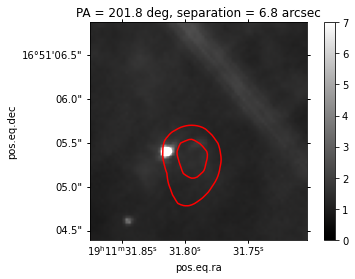

In [9]:
'''Aqui mostramos como se deberiain de ver'''
filter_ = fits.open('/home/roberto/Escritorio/wr124-jwst-nircam-2022-f090w-radec.fits')
hdu = filter_['SCI']
wcs = WCS(hdu)

j1, i1 = wcs.world_to_array_index(source_table[43]['ICRS'])
size = 40
yslice, xslice = slice(j1 - size, j1 + size), slice(i1 - size, i1 + size)
cutout = hdu.data[yslice, xslice]
wcutout = wcs.slice((yslice, xslice))

'''para contornos'''
filter_c = fits.open('/home/roberto/Escritorio/wr124-jwst-miri-2022-f1130w-radec.fits')

hdu_c = filter_c['SCI']
wcs_c = WCS(hdu_c)

j1_c, i1_c = wcs_c.world_to_array_index(source_table[43]['ICRS'])
size = 40
yslice_c, xslice_c = slice(j1_c - size, j1_c + size), slice(i1_c - size, i1_c + size)
cutout_c = hdu_c.data[yslice_c, xslice_c]
wcutout_c = wcs_c.slice((yslice_c, xslice_c))

'''para plotear'''

fig = plt.figure()
ax = fig.add_subplot(projection=wcutout)
im = ax.imshow(cutout, vmin=0.0, cmap=cm.neutral,vmax=7)
levels = cutout_c.max()*np.array([0.1,0.25,0.5,0.75,0.9])
ax.contour(cutout_c,levels,colors = 'r')
cb = fig.colorbar(im, ax=ax)
ax.set_title(f"PA = {source_table[0]['PA']:.1f}, separation = {source_table[0]['Sep']:.1f}")
...;

Set OBSGEO-B to   -31.519446 from OBSGEO-[XYZ].
Set OBSGEO-H to 1653612642.314 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


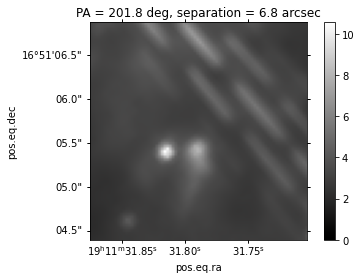

In [10]:
filter_c = fits.open('/home/roberto/Escritorio/wr124-jwst-nircam-2022-f335m-radec.fits')

hdu_c = filter_c['SCI']
wcs_c = WCS(hdu_c)

j1, i1 = wcs_c.world_to_array_index(source_table[43]['ICRS'])
size = 40
yslice, xslice = slice(j1 - size, j1 + size), slice(i1 - size, i1 + size)
cutout = hdu_c.data[yslice, xslice]
wcutout = wcs_c.slice((yslice, xslice))

fig = plt.figure()
ax = fig.add_subplot(projection=wcutout)
im = ax.imshow(cutout, vmin=0.0, cmap=cm.neutral)#,vmax=7)
cb = fig.colorbar(im, ax=ax)
ax.set_title(f"PA = {source_table[0]['PA']:.1f}, separation = {source_table[0]['Sep']:.1f}")
...;

In [11]:
len(regs)

168

In [12]:
Sel = [
    9,10,11,13,14,15,17,25,28,31,33,38,58,52,56,65,78,82,97,100,111,125,126,127,135,141,143,144,153,156
]
len(Sel)

30

Set OBSGEO-B to   -31.526408 from OBSGEO-[XYZ].
Set OBSGEO-H to 1653717953.818 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -34.083187 from OBSGEO-[XYZ].
Set OBSGEO-H to 1694947246.087 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -31.526408 from OBSGEO-[XYZ].
Set OBSGEO-H to 1653717953.818 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -31.526408 from OBSGEO-[XYZ].
Set OBSGEO-H to 1653717953.818 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -34.083187 from OBSGEO-[XYZ].
Set OBSGEO-H to 1694947246.087 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -31.526408 from OBSGEO-[XYZ].
Set OBSGEO-H to 1653717953.818 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -31.526408 from OBSGEO-[XYZ].
Set OBSGEO-H to 1653717953.818 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -34.083187 from OBSGEO-[XYZ].
Set OBSGEO-H to 1694947246.087 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -31.526408 from OBSGEO-[XYZ].
Set OBSGEO-H to 

Set OBSGEO-B to   -31.526408 from OBSGEO-[XYZ].
Set OBSGEO-H to 1653717953.818 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -31.526408 from OBSGEO-[XYZ].
Set OBSGEO-H to 1653717953.818 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -34.083187 from OBSGEO-[XYZ].
Set OBSGEO-H to 1694947246.087 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -31.526408 from OBSGEO-[XYZ].
Set OBSGEO-H to 1653717953.818 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -31.526408 from OBSGEO-[XYZ].
Set OBSGEO-H to 1653717953.818 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -34.083187 from OBSGEO-[XYZ].
Set OBSGEO-H to 1694947246.087 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -31.526408 from OBSGEO-[XYZ].
Set OBSGEO-H to 1653717953.818 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -31.526408 from OBSGEO-[XYZ].
Set OBSGEO-H to 1653717953.818 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -34.083187 from OBSGEO-[XYZ].
Set OBSGEO-H to 

Set OBSGEO-B to   -31.526408 from OBSGEO-[XYZ].
Set OBSGEO-H to 1653717953.818 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -31.526408 from OBSGEO-[XYZ].
Set OBSGEO-H to 1653717953.818 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -34.083187 from OBSGEO-[XYZ].
Set OBSGEO-H to 1694947246.087 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -31.526408 from OBSGEO-[XYZ].
Set OBSGEO-H to 1653717953.818 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -31.526408 from OBSGEO-[XYZ].
Set OBSGEO-H to 1653717953.818 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -34.083187 from OBSGEO-[XYZ].
Set OBSGEO-H to 1694947246.087 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -31.526408 from OBSGEO-[XYZ].
Set OBSGEO-H to 1653717953.818 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -31.526408 from OBSGEO-[XYZ].
Set OBSGEO-H to 1653717953.818 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -34.083187 from OBSGEO-[XYZ].
Set OBSGEO-H to 

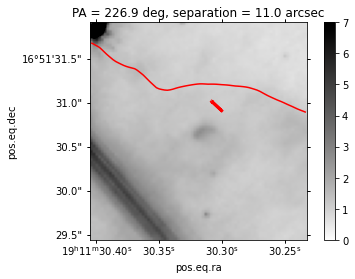

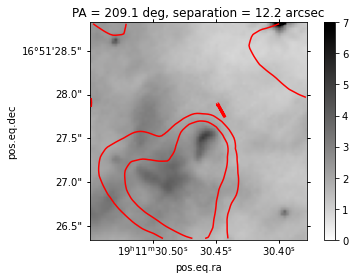

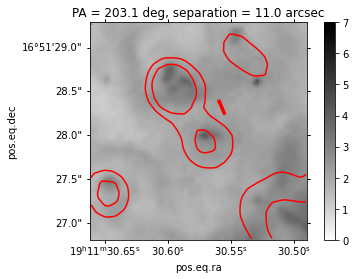

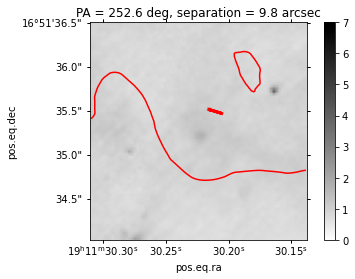

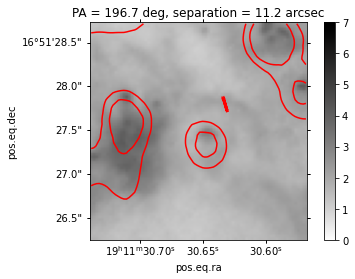

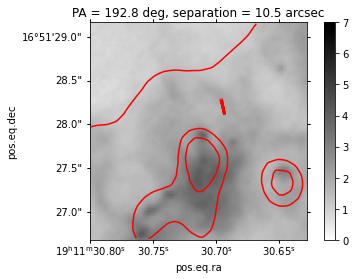

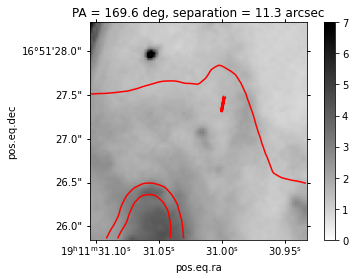

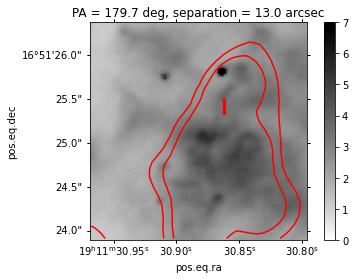

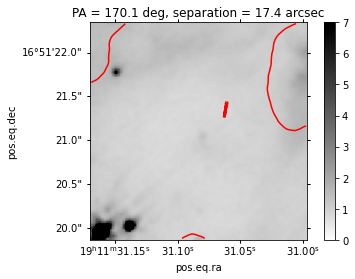

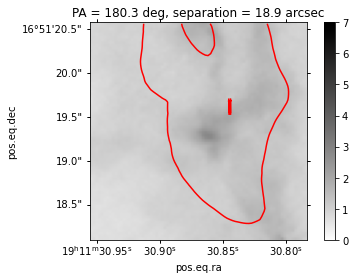

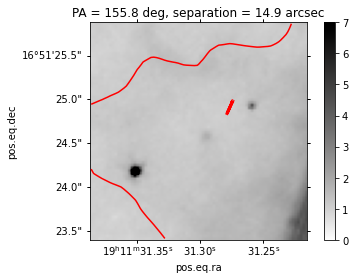

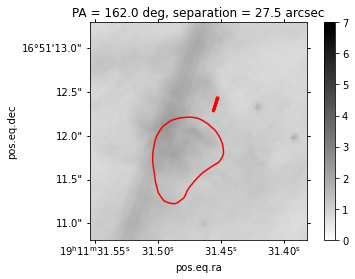

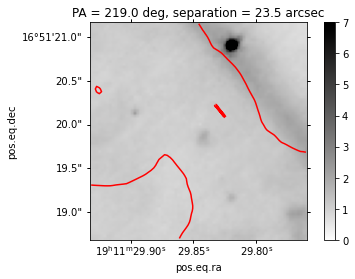

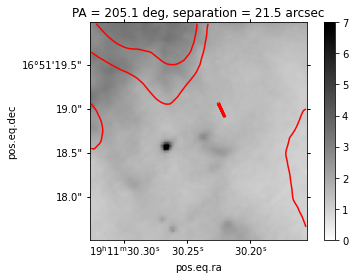

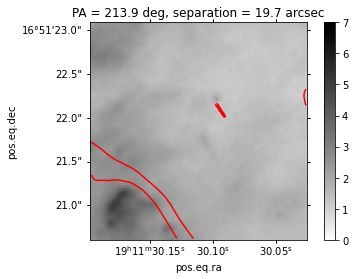

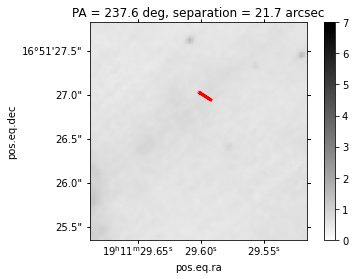

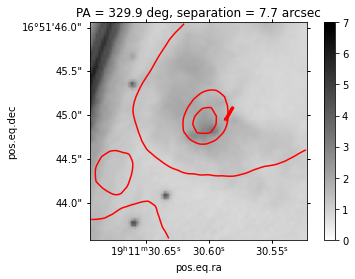

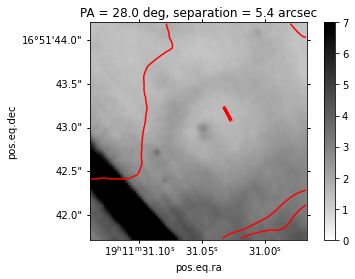

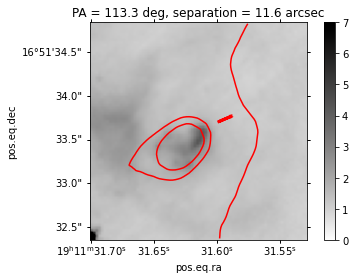

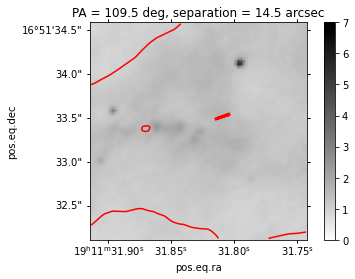

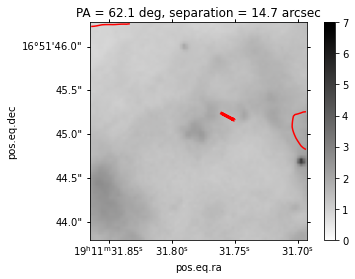

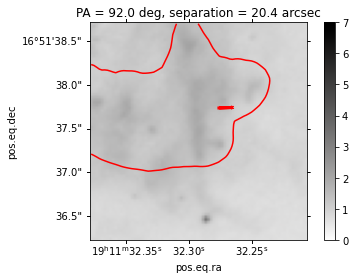

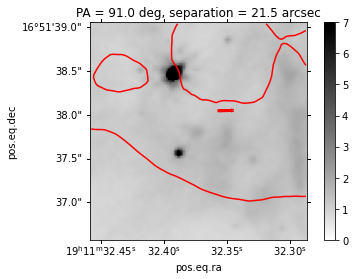

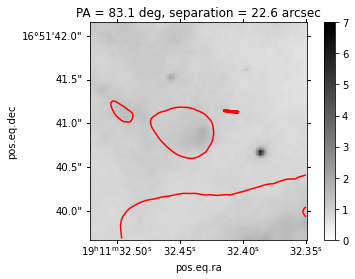

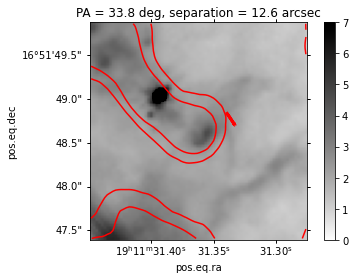

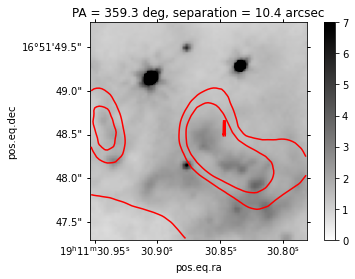

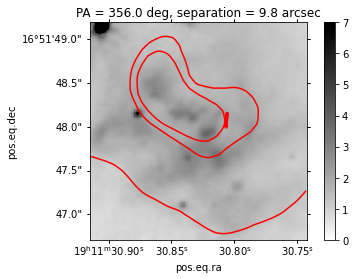

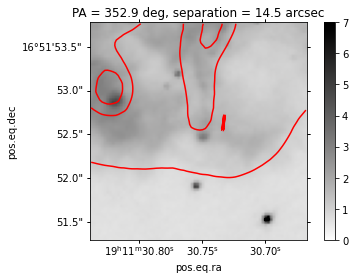

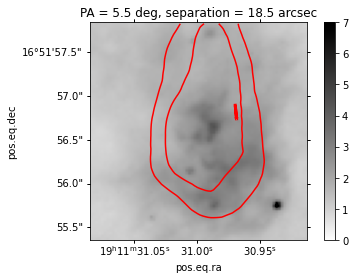

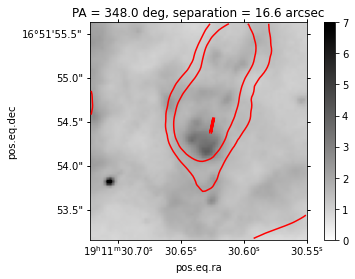

In [28]:
for i in Sel:
    '''Aqui mostramos como se deberiain de ver'''
    filter_ = fits.open('/home/roberto/Escritorio/wr124-jwst-nircam-2022-f090w-radec.fits')
    hdu = filter_['SCI']
    wcs = WCS(hdu)

    j1, i1 = wcs.world_to_array_index(source_table[i]['ICRS'])
    size = 40
    yslice, xslice = slice(j1 - size, j1 + size), slice(i1 - size, i1 + size)
    cutout = hdu.data[yslice, xslice]
    wcutout = wcs.slice((yslice, xslice))

    '''para contornos'''
    filter_c = fits.open('/home/roberto/Escritorio/wr124-jwst-miri-2022-f1130w-radec.fits')

    hdu_c = filter_c['SCI']
    wcs_c = WCS(hdu_c)

    j1_c, i1_c = wcs_c.world_to_array_index(source_table[i]['ICRS'])
    size = 40
    yslice_c, xslice_c = slice(j1_c - size, j1_c + size), slice(i1_c - size, i1_c + size)
    cutout_c = hdu_c.data[yslice_c, xslice_c]
    wcutout_c = wcs_c.slice((yslice_c, xslice_c))

    '''para plotear'''

    fig = plt.figure()
    ax = fig.add_subplot(projection=wcutout)
    im = ax.imshow(cutout, vmin=0.0, cmap=cm.neutral_r,vmax=7)
    levels = np.array([40,80,100])
    ax.contour(cutout_c,levels,colors = 'r')
    arrow_length = 5.0
   # y1, x1 = wcs.world_to_array_index(source_table[i]['ICRS'])
    
    cutout = SourceCutout(source_table[i], hdu)
    y1, x1 = cutout.wcs.world_to_array_index(cutout.barycenter)
    dx, dy = -arrow_length * np.sin(cutout.pa_star), arrow_length * np.cos(cutout.pa_star)
    ax.arrow(x1, y1, dx, dy, color='r', lw=3)
    cb = fig.colorbar(im, ax=ax)
    ax.set_title(f"PA = {source_table[i]['PA']:.1f}, separation = {source_table[i]['Sep']:.1f}")
    fig.savefig(rf'source_{i}.pdf')
    ...;

In [16]:
cutouts = [SourceCutout(source, hdu) for source in source_table]
cutouts = sorted(cutouts, key=lambda x: x.sep.value)

best_cutouts = [cutout for cutout in cutouts if cutout.is_isolated]

cutouts_c = [SourceCutout(source, hdu_c) for source in source_table]
cutouts_c = sorted(cutouts_c, key=lambda x: x.sep.value)

best_cutouts_c = [cutout for cutout in cutouts_c if cutout.is_isolated]


Set OBSGEO-B to   -31.526408 from OBSGEO-[XYZ].
Set OBSGEO-H to 1653717953.818 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -31.526408 from OBSGEO-[XYZ].
Set OBSGEO-H to 1653717953.818 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -31.526408 from OBSGEO-[XYZ].
Set OBSGEO-H to 1653717953.818 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -31.526408 from OBSGEO-[XYZ].
Set OBSGEO-H to 1653717953.818 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -31.526408 from OBSGEO-[XYZ].
Set OBSGEO-H to 1653717953.818 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -31.526408 from OBSGEO-[XYZ].
Set OBSGEO-H to 1653717953.818 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -31.526408 from OBSGEO-[XYZ].
Set OBSGEO-H to 1653717953.818 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -31.526408 from OBSGEO-[XYZ].
Set OBSGEO-H to 1653717953.818 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -31.526408 from OBSGEO-[XYZ].
Set OBSGEO-H to 

Set OBSGEO-B to   -31.526408 from OBSGEO-[XYZ].
Set OBSGEO-H to 1653717953.818 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -31.526408 from OBSGEO-[XYZ].
Set OBSGEO-H to 1653717953.818 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -31.526408 from OBSGEO-[XYZ].
Set OBSGEO-H to 1653717953.818 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -31.526408 from OBSGEO-[XYZ].
Set OBSGEO-H to 1653717953.818 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -31.526408 from OBSGEO-[XYZ].
Set OBSGEO-H to 1653717953.818 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -31.526408 from OBSGEO-[XYZ].
Set OBSGEO-H to 1653717953.818 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -31.526408 from OBSGEO-[XYZ].
Set OBSGEO-H to 1653717953.818 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -31.526408 from OBSGEO-[XYZ].
Set OBSGEO-H to 1653717953.818 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -31.526408 from OBSGEO-[XYZ].
Set OBSGEO-H to 

Set OBSGEO-B to   -31.526408 from OBSGEO-[XYZ].
Set OBSGEO-H to 1653717953.818 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -31.526408 from OBSGEO-[XYZ].
Set OBSGEO-H to 1653717953.818 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -31.526408 from OBSGEO-[XYZ].
Set OBSGEO-H to 1653717953.818 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -31.526408 from OBSGEO-[XYZ].
Set OBSGEO-H to 1653717953.818 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -31.526408 from OBSGEO-[XYZ].
Set OBSGEO-H to 1653717953.818 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -31.526408 from OBSGEO-[XYZ].
Set OBSGEO-H to 1653717953.818 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -31.526408 from OBSGEO-[XYZ].
Set OBSGEO-H to 1653717953.818 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -31.526408 from OBSGEO-[XYZ].
Set OBSGEO-H to 1653717953.818 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -31.526408 from OBSGEO-[XYZ].
Set OBSGEO-H to 

Set OBSGEO-B to   -31.526408 from OBSGEO-[XYZ].
Set OBSGEO-H to 1653717953.818 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -31.526408 from OBSGEO-[XYZ].
Set OBSGEO-H to 1653717953.818 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -31.526408 from OBSGEO-[XYZ].
Set OBSGEO-H to 1653717953.818 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -31.526408 from OBSGEO-[XYZ].
Set OBSGEO-H to 1653717953.818 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -31.526408 from OBSGEO-[XYZ].
Set OBSGEO-H to 1653717953.818 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -31.526408 from OBSGEO-[XYZ].
Set OBSGEO-H to 1653717953.818 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -31.526408 from OBSGEO-[XYZ].
Set OBSGEO-H to 1653717953.818 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -31.526408 from OBSGEO-[XYZ].
Set OBSGEO-H to 1653717953.818 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -31.526408 from OBSGEO-[XYZ].
Set OBSGEO-H to 

Set OBSGEO-B to   -31.526408 from OBSGEO-[XYZ].
Set OBSGEO-H to 1653717953.818 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -31.526408 from OBSGEO-[XYZ].
Set OBSGEO-H to 1653717953.818 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -31.526408 from OBSGEO-[XYZ].
Set OBSGEO-H to 1653717953.818 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -31.526408 from OBSGEO-[XYZ].
Set OBSGEO-H to 1653717953.818 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -31.526408 from OBSGEO-[XYZ].
Set OBSGEO-H to 1653717953.818 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -31.526408 from OBSGEO-[XYZ].
Set OBSGEO-H to 1653717953.818 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -31.526408 from OBSGEO-[XYZ].
Set OBSGEO-H to 1653717953.818 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -31.526408 from OBSGEO-[XYZ].
Set OBSGEO-H to 1653717953.818 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -31.526408 from OBSGEO-[XYZ].
Set OBSGEO-H to 

Set OBSGEO-B to   -34.083187 from OBSGEO-[XYZ].
Set OBSGEO-H to 1694947246.087 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -34.083187 from OBSGEO-[XYZ].
Set OBSGEO-H to 1694947246.087 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -34.083187 from OBSGEO-[XYZ].
Set OBSGEO-H to 1694947246.087 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -34.083187 from OBSGEO-[XYZ].
Set OBSGEO-H to 1694947246.087 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -34.083187 from OBSGEO-[XYZ].
Set OBSGEO-H to 1694947246.087 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -34.083187 from OBSGEO-[XYZ].
Set OBSGEO-H to 1694947246.087 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -34.083187 from OBSGEO-[XYZ].
Set OBSGEO-H to 1694947246.087 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -34.083187 from OBSGEO-[XYZ].
Set OBSGEO-H to 1694947246.087 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -34.083187 from OBSGEO-[XYZ].
Set OBSGEO-H to 

Set OBSGEO-B to   -34.083187 from OBSGEO-[XYZ].
Set OBSGEO-H to 1694947246.087 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -34.083187 from OBSGEO-[XYZ].
Set OBSGEO-H to 1694947246.087 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -34.083187 from OBSGEO-[XYZ].
Set OBSGEO-H to 1694947246.087 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -34.083187 from OBSGEO-[XYZ].
Set OBSGEO-H to 1694947246.087 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -34.083187 from OBSGEO-[XYZ].
Set OBSGEO-H to 1694947246.087 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -34.083187 from OBSGEO-[XYZ].
Set OBSGEO-H to 1694947246.087 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -34.083187 from OBSGEO-[XYZ].
Set OBSGEO-H to 1694947246.087 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -34.083187 from OBSGEO-[XYZ].
Set OBSGEO-H to 1694947246.087 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -34.083187 from OBSGEO-[XYZ].
Set OBSGEO-H to 

Set OBSGEO-B to   -34.083187 from OBSGEO-[XYZ].
Set OBSGEO-H to 1694947246.087 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -34.083187 from OBSGEO-[XYZ].
Set OBSGEO-H to 1694947246.087 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -34.083187 from OBSGEO-[XYZ].
Set OBSGEO-H to 1694947246.087 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -34.083187 from OBSGEO-[XYZ].
Set OBSGEO-H to 1694947246.087 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -34.083187 from OBSGEO-[XYZ].
Set OBSGEO-H to 1694947246.087 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -34.083187 from OBSGEO-[XYZ].
Set OBSGEO-H to 1694947246.087 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -34.083187 from OBSGEO-[XYZ].
Set OBSGEO-H to 1694947246.087 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -34.083187 from OBSGEO-[XYZ].
Set OBSGEO-H to 1694947246.087 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -34.083187 from OBSGEO-[XYZ].
Set OBSGEO-H to 

Set OBSGEO-B to   -34.083187 from OBSGEO-[XYZ].
Set OBSGEO-H to 1694947246.087 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -34.083187 from OBSGEO-[XYZ].
Set OBSGEO-H to 1694947246.087 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -34.083187 from OBSGEO-[XYZ].
Set OBSGEO-H to 1694947246.087 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -34.083187 from OBSGEO-[XYZ].
Set OBSGEO-H to 1694947246.087 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -34.083187 from OBSGEO-[XYZ].
Set OBSGEO-H to 1694947246.087 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -34.083187 from OBSGEO-[XYZ].
Set OBSGEO-H to 1694947246.087 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -34.083187 from OBSGEO-[XYZ].
Set OBSGEO-H to 1694947246.087 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -34.083187 from OBSGEO-[XYZ].
Set OBSGEO-H to 1694947246.087 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -34.083187 from OBSGEO-[XYZ].
Set OBSGEO-H to 

<ipython-input-17-67714f2639bb>:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure()


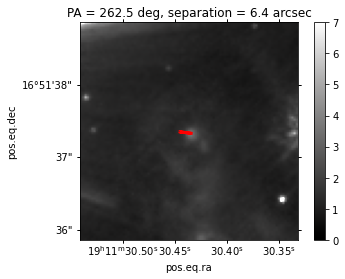

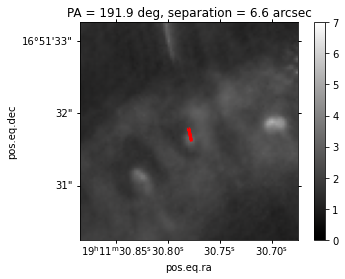

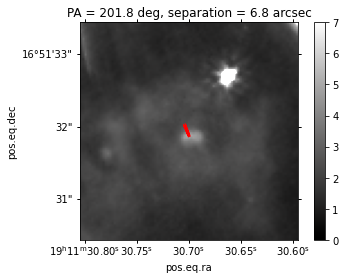

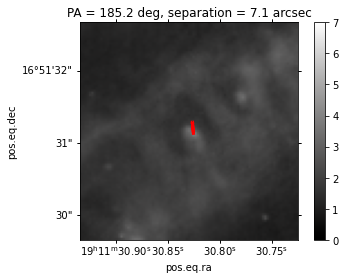

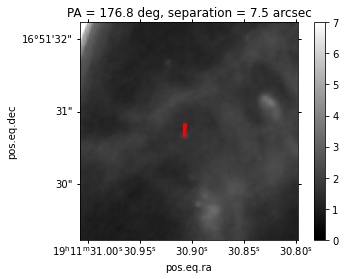

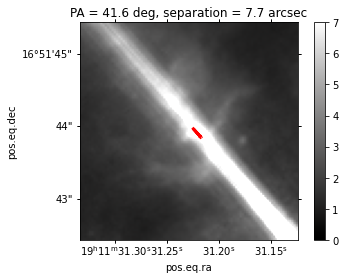

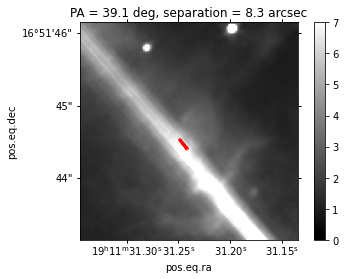

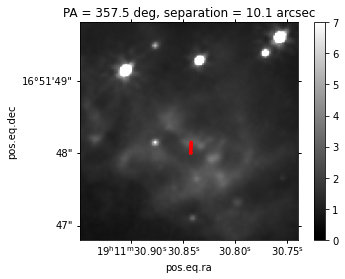

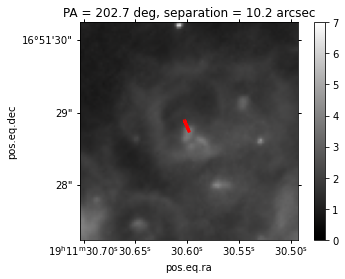

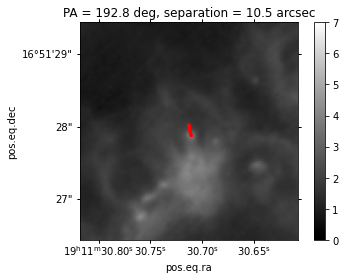

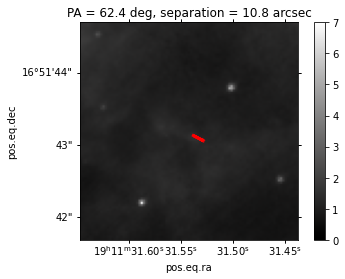

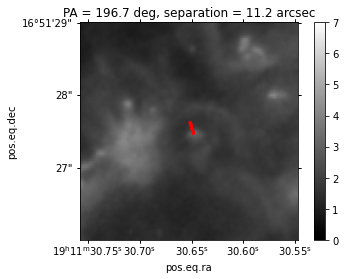

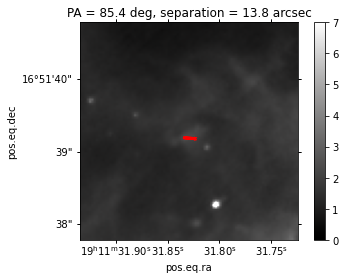

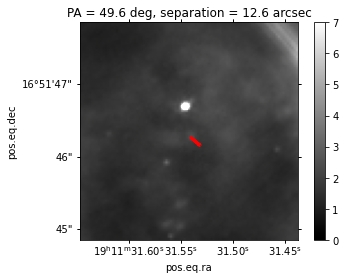

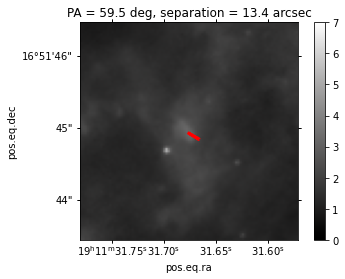

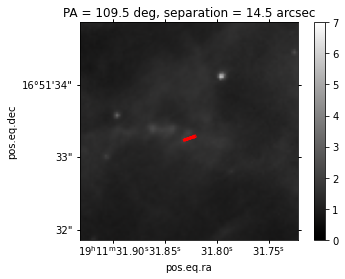

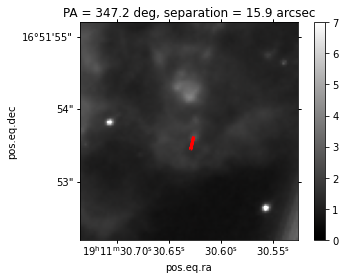

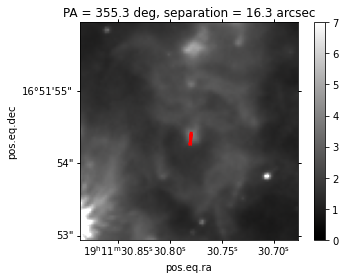

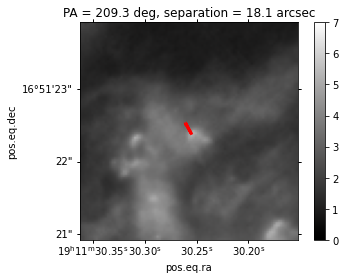

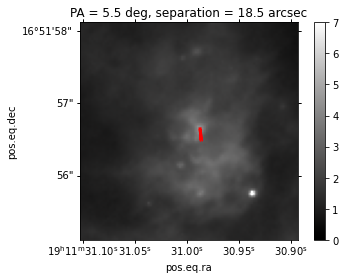

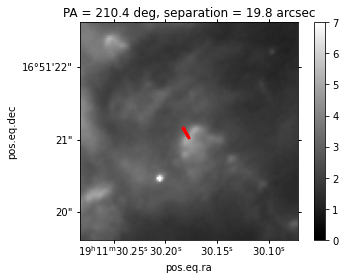

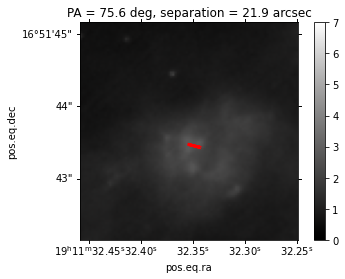

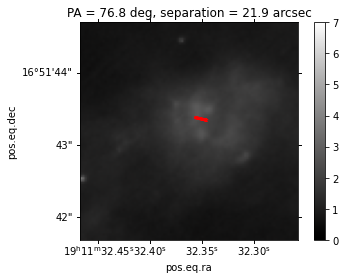

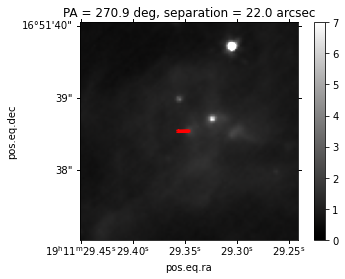

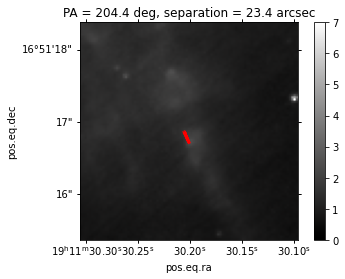

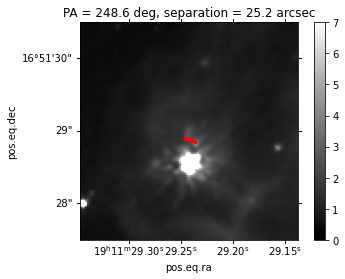

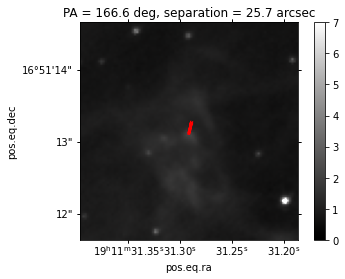

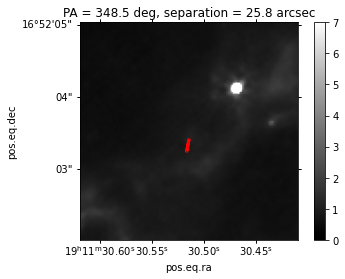

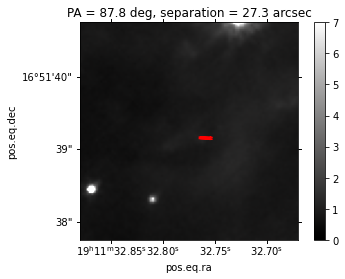

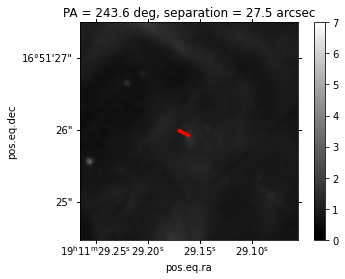

In [17]:
for i in Sel:
    cutout = cutouts[i]
    fig = plt.figure()
    ax = fig.add_subplot(projection=cutout.wcs)
    im = ax.imshow(
        cutout.image,
        vmin=0.0, 
        vmax=7,
        cmap=cm.neutral,
        )
    cb = fig.colorbar(im, ax=ax)
    #ax.imshow(np.where(cutout.mask, np.nan, 1.0), vmin=0, vmax=1, cmap=cm.gem, alpha=0.3)
    y1, x1 = cutout.wcs.world_to_array_index(cutout.barycenter)
    arrow_length = 5.0
    dx, dy = -arrow_length * np.sin(cutout.pa_star), arrow_length * np.cos(cutout.pa_star)
    ax.arrow(x1, y1, dx, dy, color='r', lw=3)
    ax.set_title(f"PA = {cutout.pa_source:.1f}, separation = {cutout.sep:.1f}")

<ipython-input-18-bbab38741163>:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure()


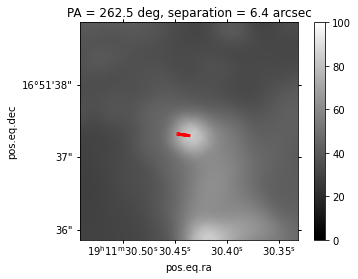

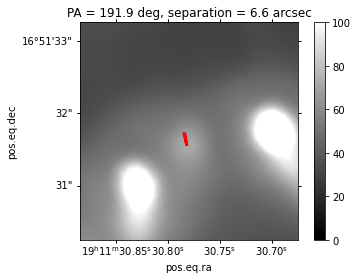

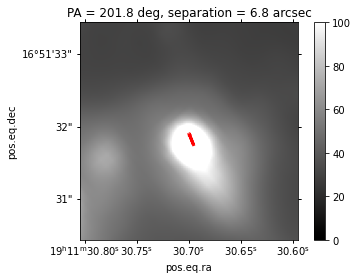

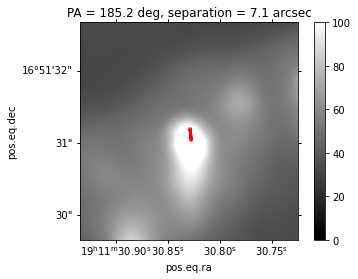

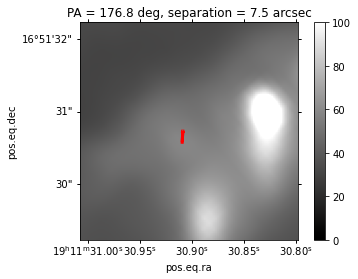

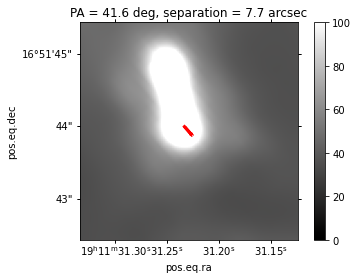

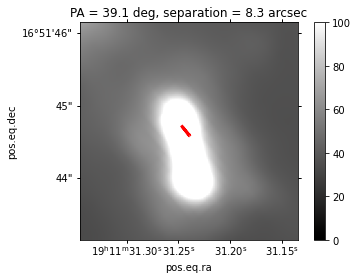

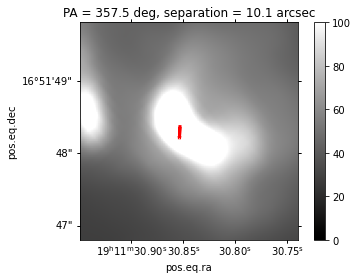

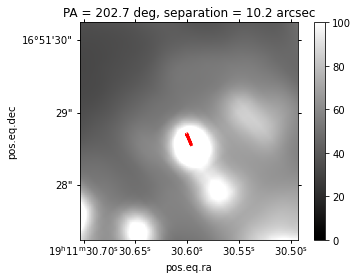

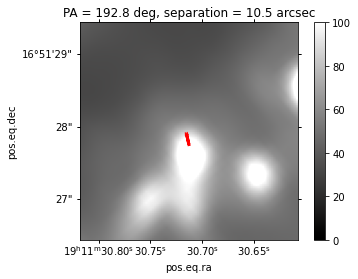

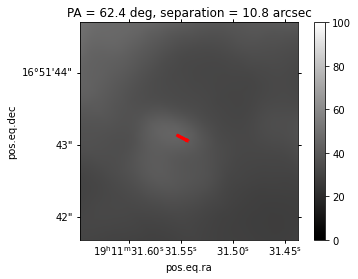

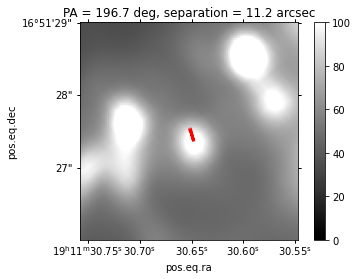

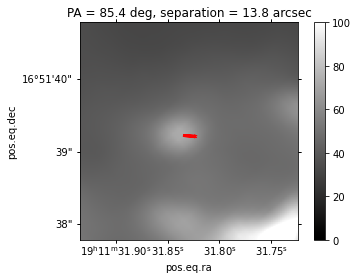

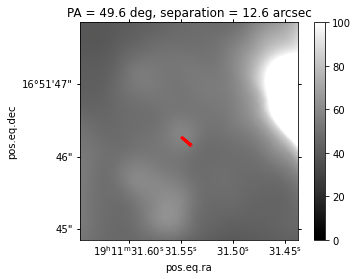

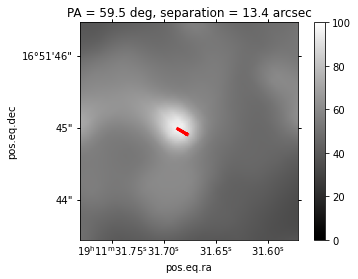

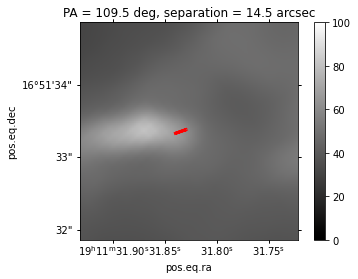

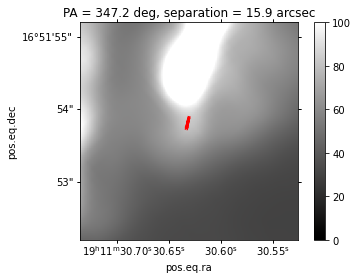

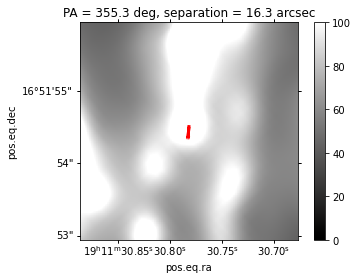

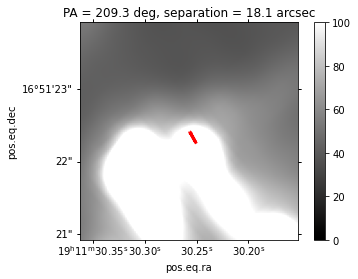

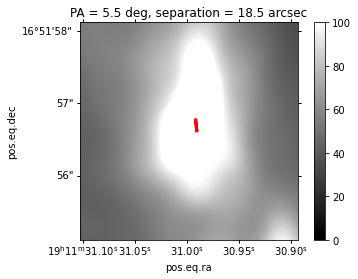

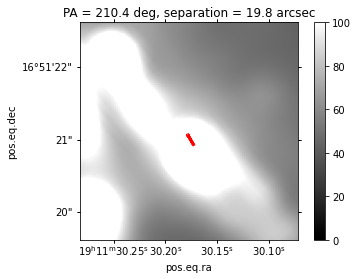

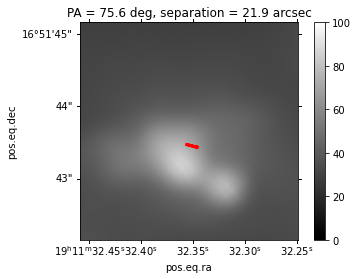

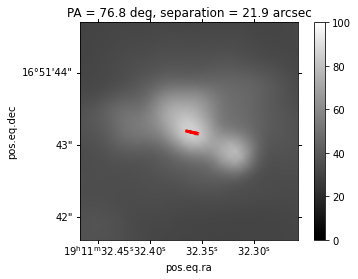

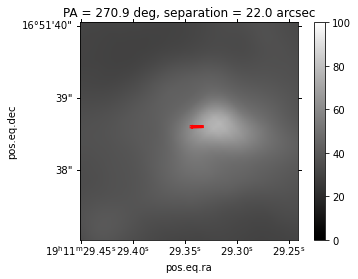

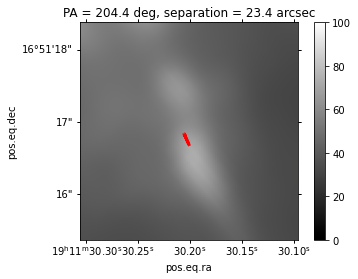

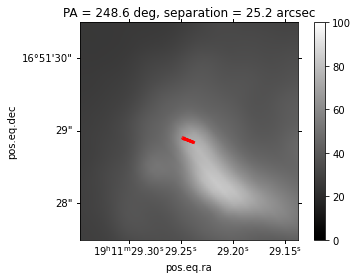

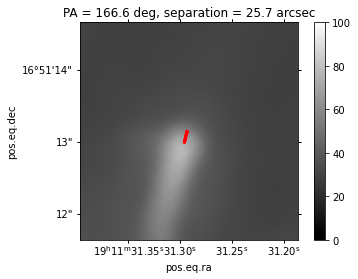

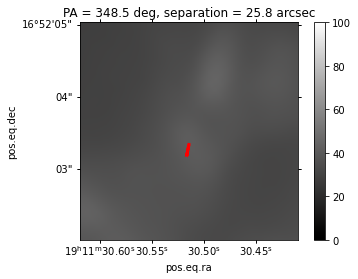

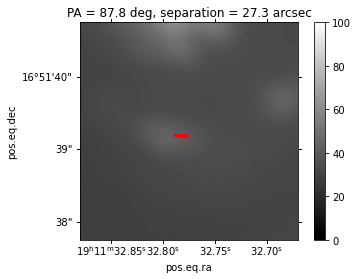

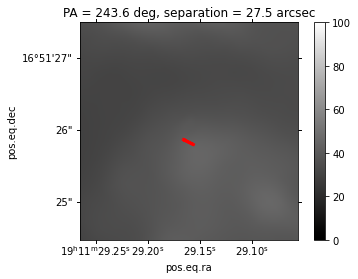

In [18]:
for i in Sel:
    cutout = cutouts_c[i]
    fig = plt.figure()
    ax = fig.add_subplot(projection=cutout.wcs)
    im = ax.imshow(
        cutout.image,
        vmin=0.0, 
        vmax=100,
        cmap=cm.neutral,
        )
    cb = fig.colorbar(im, ax=ax)
    #ax.imshow(np.where(cutout.mask, np.nan, 1.0), vmin=0, vmax=1, cmap=cm.gem, alpha=0.3)
    y1, x1 = cutout.wcs.world_to_array_index(cutout.barycenter)
    arrow_length = 5.0
    dx, dy = -arrow_length * np.sin(cutout.pa_star), arrow_length * np.cos(cutout.pa_star)
    ax.arrow(x1, y1, dx, dy, color='r', lw=3)
    ax.set_title(f"PA = {cutout.pa_source:.1f}, separation = {cutout.sep:.1f}")

In [19]:
filter_3 = fits.open('/home/roberto/Escritorio/wr124-jwst-nircam-2022-f335m-radec.fits')

hdu_3 = filter_3['SCI']
wcs_3 = WCS(hdu_3)
cutouts_3 = [SourceCutout(source, hdu_3) for source in source_table]
cutouts_3 = sorted(cutouts_3, key=lambda x: x.sep.value)

best_cutouts_3 = [cutout for cutout in cutouts_3 if cutout.is_isolated]

Set OBSGEO-B to   -31.519446 from OBSGEO-[XYZ].
Set OBSGEO-H to 1653612642.314 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -31.519446 from OBSGEO-[XYZ].
Set OBSGEO-H to 1653612642.314 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -31.519446 from OBSGEO-[XYZ].
Set OBSGEO-H to 1653612642.314 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -31.519446 from OBSGEO-[XYZ].
Set OBSGEO-H to 1653612642.314 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -31.519446 from OBSGEO-[XYZ].
Set OBSGEO-H to 1653612642.314 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -31.519446 from OBSGEO-[XYZ].
Set OBSGEO-H to 1653612642.314 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -31.519446 from OBSGEO-[XYZ].
Set OBSGEO-H to 1653612642.314 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -31.519446 from OBSGEO-[XYZ].
Set OBSGEO-H to 1653612642.314 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -31.519446 from OBSGEO-[XYZ].
Set OBSGEO-H to 

Set OBSGEO-B to   -31.519446 from OBSGEO-[XYZ].
Set OBSGEO-H to 1653612642.314 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -31.519446 from OBSGEO-[XYZ].
Set OBSGEO-H to 1653612642.314 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -31.519446 from OBSGEO-[XYZ].
Set OBSGEO-H to 1653612642.314 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -31.519446 from OBSGEO-[XYZ].
Set OBSGEO-H to 1653612642.314 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -31.519446 from OBSGEO-[XYZ].
Set OBSGEO-H to 1653612642.314 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -31.519446 from OBSGEO-[XYZ].
Set OBSGEO-H to 1653612642.314 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -31.519446 from OBSGEO-[XYZ].
Set OBSGEO-H to 1653612642.314 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -31.519446 from OBSGEO-[XYZ].
Set OBSGEO-H to 1653612642.314 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -31.519446 from OBSGEO-[XYZ].
Set OBSGEO-H to 

Set OBSGEO-B to   -31.519446 from OBSGEO-[XYZ].
Set OBSGEO-H to 1653612642.314 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -31.519446 from OBSGEO-[XYZ].
Set OBSGEO-H to 1653612642.314 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -31.519446 from OBSGEO-[XYZ].
Set OBSGEO-H to 1653612642.314 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -31.519446 from OBSGEO-[XYZ].
Set OBSGEO-H to 1653612642.314 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -31.519446 from OBSGEO-[XYZ].
Set OBSGEO-H to 1653612642.314 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -31.519446 from OBSGEO-[XYZ].
Set OBSGEO-H to 1653612642.314 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -31.519446 from OBSGEO-[XYZ].
Set OBSGEO-H to 1653612642.314 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -31.519446 from OBSGEO-[XYZ].
Set OBSGEO-H to 1653612642.314 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -31.519446 from OBSGEO-[XYZ].
Set OBSGEO-H to 

Set OBSGEO-B to   -31.519446 from OBSGEO-[XYZ].
Set OBSGEO-H to 1653612642.314 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -31.519446 from OBSGEO-[XYZ].
Set OBSGEO-H to 1653612642.314 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -31.519446 from OBSGEO-[XYZ].
Set OBSGEO-H to 1653612642.314 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -31.519446 from OBSGEO-[XYZ].
Set OBSGEO-H to 1653612642.314 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -31.519446 from OBSGEO-[XYZ].
Set OBSGEO-H to 1653612642.314 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -31.519446 from OBSGEO-[XYZ].
Set OBSGEO-H to 1653612642.314 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -31.519446 from OBSGEO-[XYZ].
Set OBSGEO-H to 1653612642.314 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -31.519446 from OBSGEO-[XYZ].
Set OBSGEO-H to 1653612642.314 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -31.519446 from OBSGEO-[XYZ].
Set OBSGEO-H to 

Set OBSGEO-B to   -31.519446 from OBSGEO-[XYZ].
Set OBSGEO-H to 1653612642.314 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -31.519446 from OBSGEO-[XYZ].
Set OBSGEO-H to 1653612642.314 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -31.519446 from OBSGEO-[XYZ].
Set OBSGEO-H to 1653612642.314 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -31.519446 from OBSGEO-[XYZ].
Set OBSGEO-H to 1653612642.314 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -31.519446 from OBSGEO-[XYZ].
Set OBSGEO-H to 1653612642.314 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -31.519446 from OBSGEO-[XYZ].
Set OBSGEO-H to 1653612642.314 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -31.519446 from OBSGEO-[XYZ].
Set OBSGEO-H to 1653612642.314 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -31.519446 from OBSGEO-[XYZ].
Set OBSGEO-H to 1653612642.314 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -31.519446 from OBSGEO-[XYZ].
Set OBSGEO-H to 

<ipython-input-20-e2ed7d0eafa4>:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure()


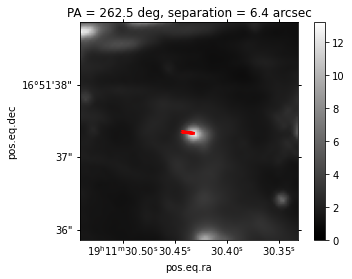

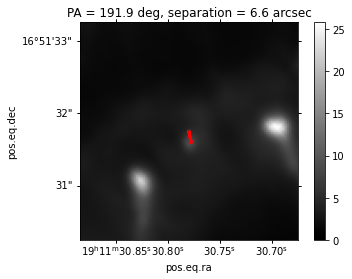

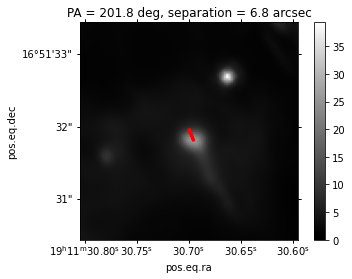

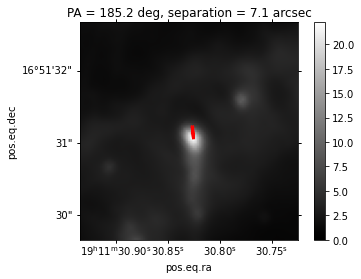

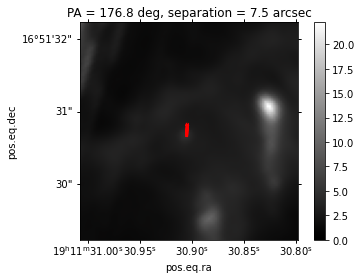

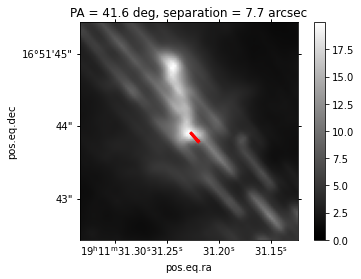

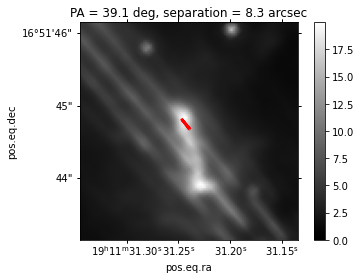

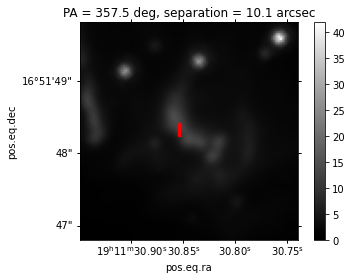

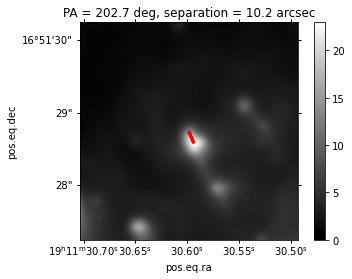

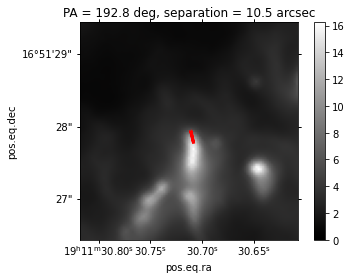

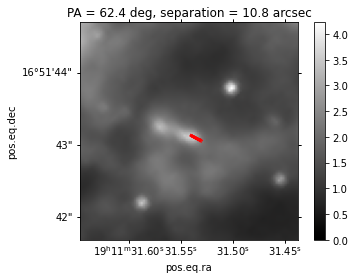

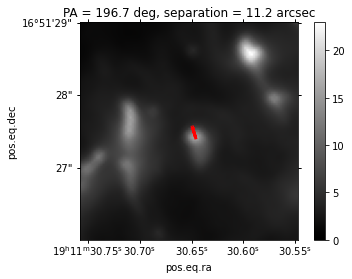

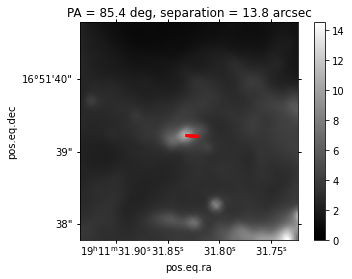

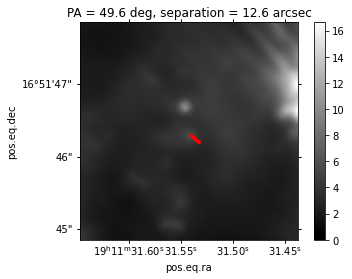

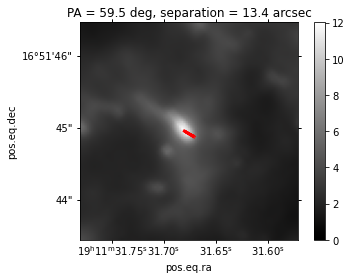

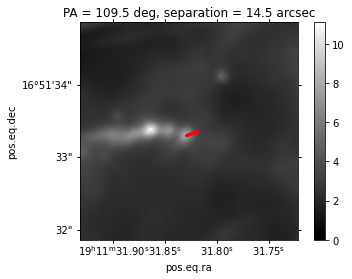

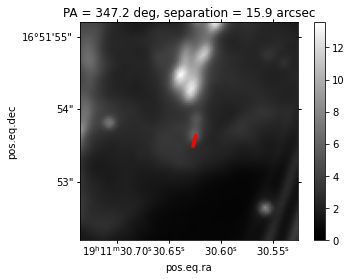

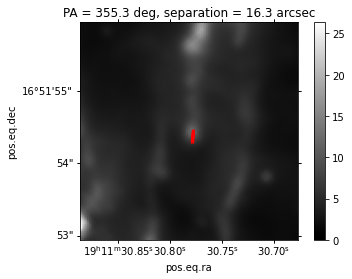

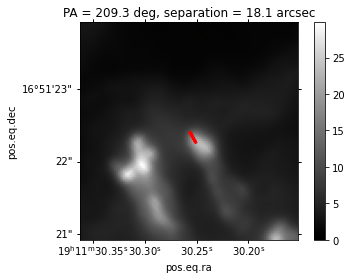

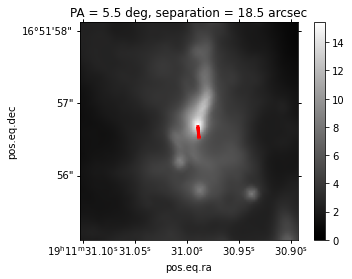

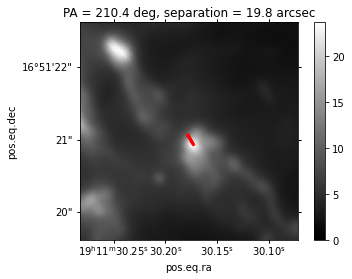

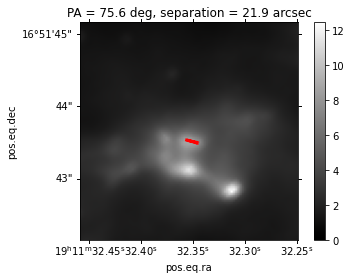

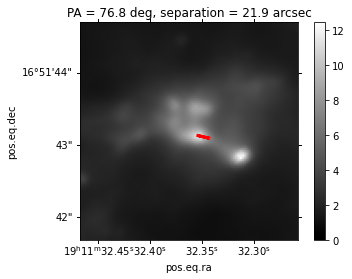

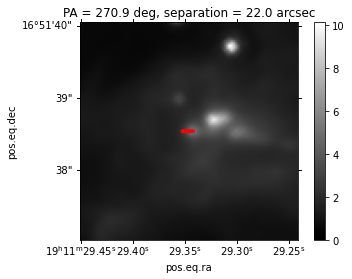

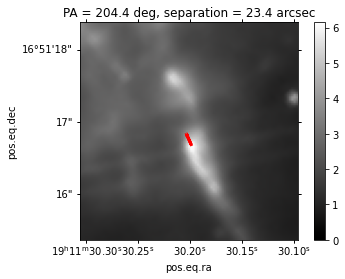

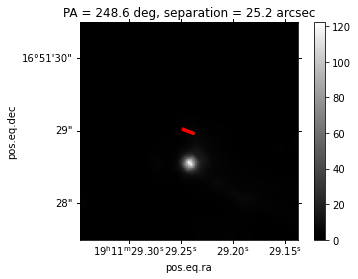

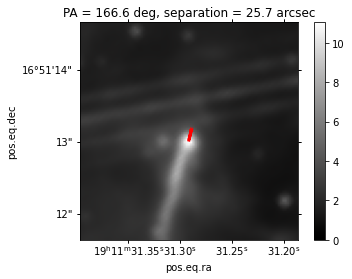

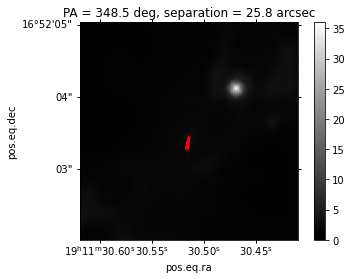

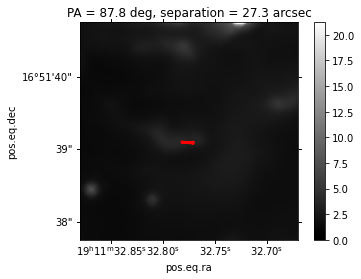

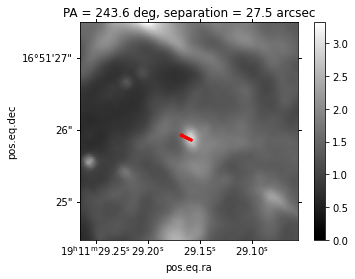

In [20]:
for i in Sel:
    cutout = cutouts_3[i]
    fig = plt.figure()
    ax = fig.add_subplot(projection=cutout.wcs)
    im = ax.imshow(
        cutout.image,
        vmin=0.0, 
        cmap=cm.neutral,
        )
    cb = fig.colorbar(im, ax=ax)
    #ax.imshow(np.where(cutout.mask, np.nan, 1.0), vmin=0, vmax=1, cmap=cm.gem, alpha=0.3)
    y1, x1 = cutout.wcs.world_to_array_index(cutout.barycenter)
    arrow_length = 5.0
    dx, dy = -arrow_length * np.sin(cutout.pa_star), arrow_length * np.cos(cutout.pa_star)
    ax.arrow(x1, y1, dx, dy, color='r', lw=3)
    ax.set_title(f"PA = {cutout.pa_source:.1f}, separation = {cutout.sep:.1f}")

<ipython-input-27-d7f00a956a3a>:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig =plt.figure(figsize=(26,26))


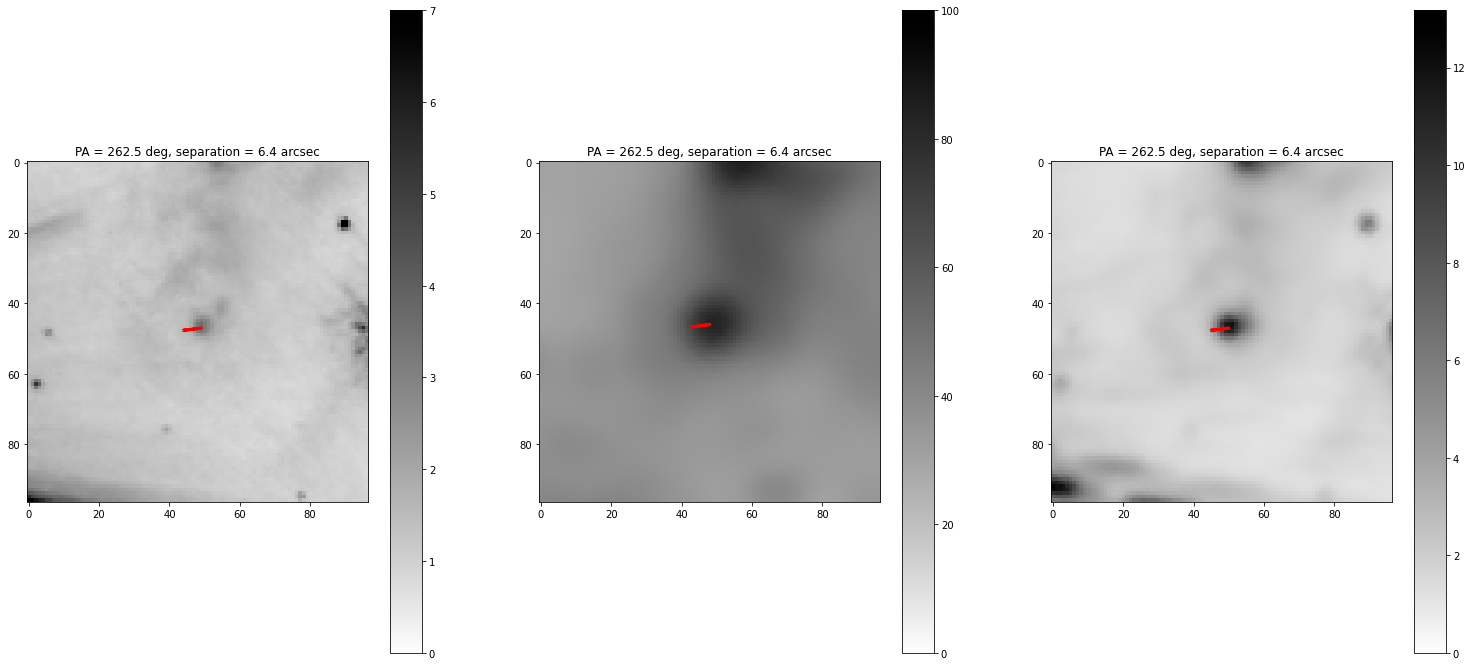

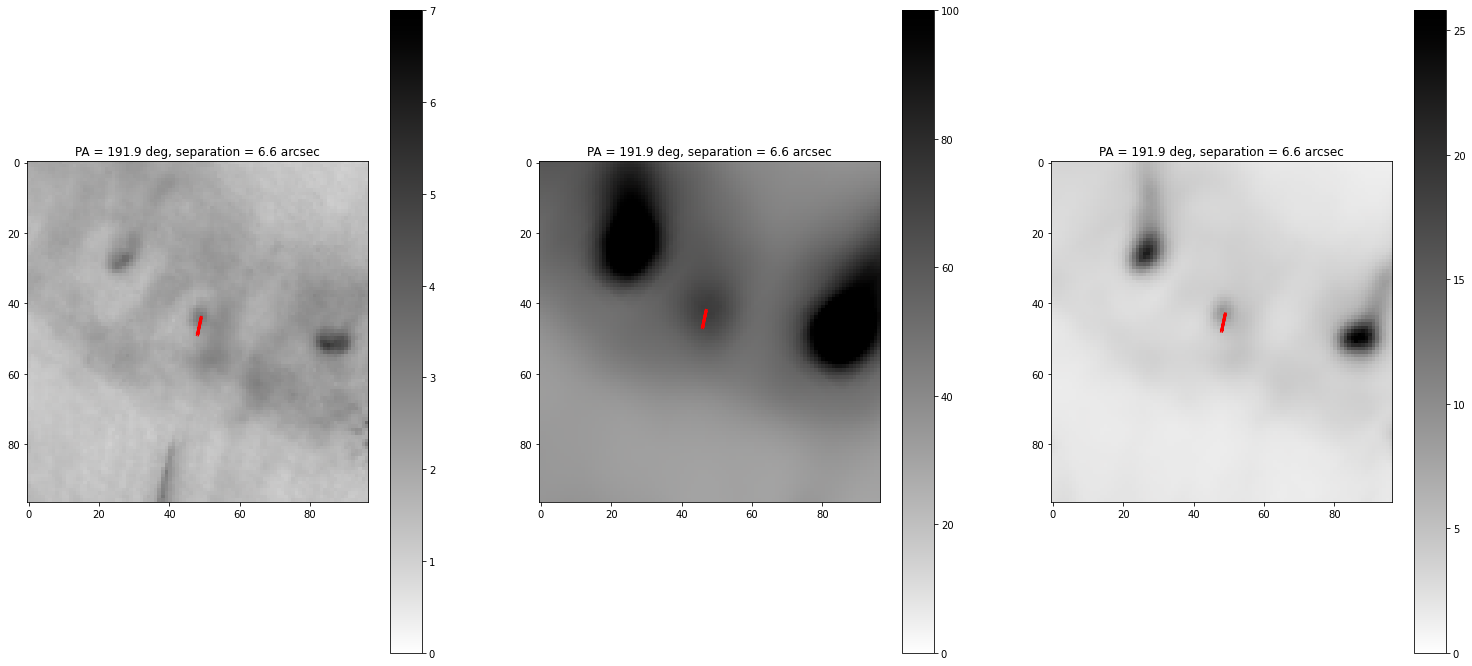

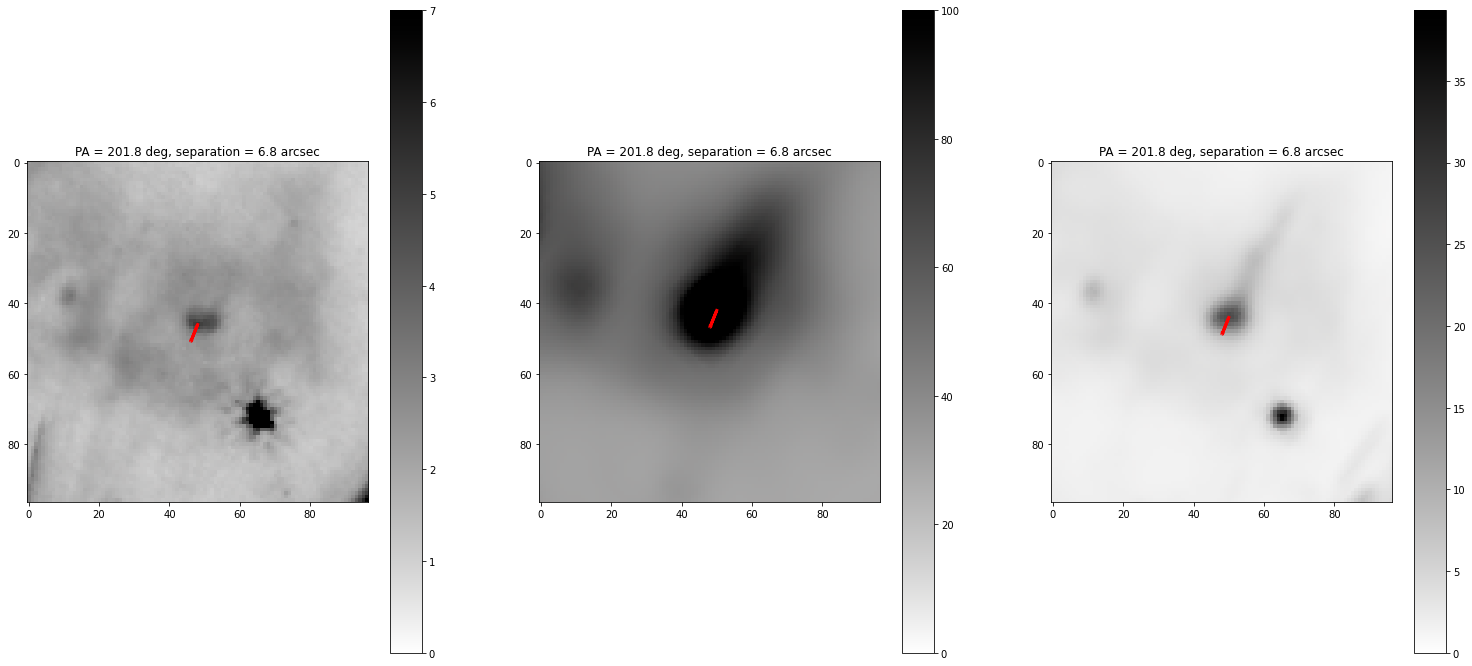

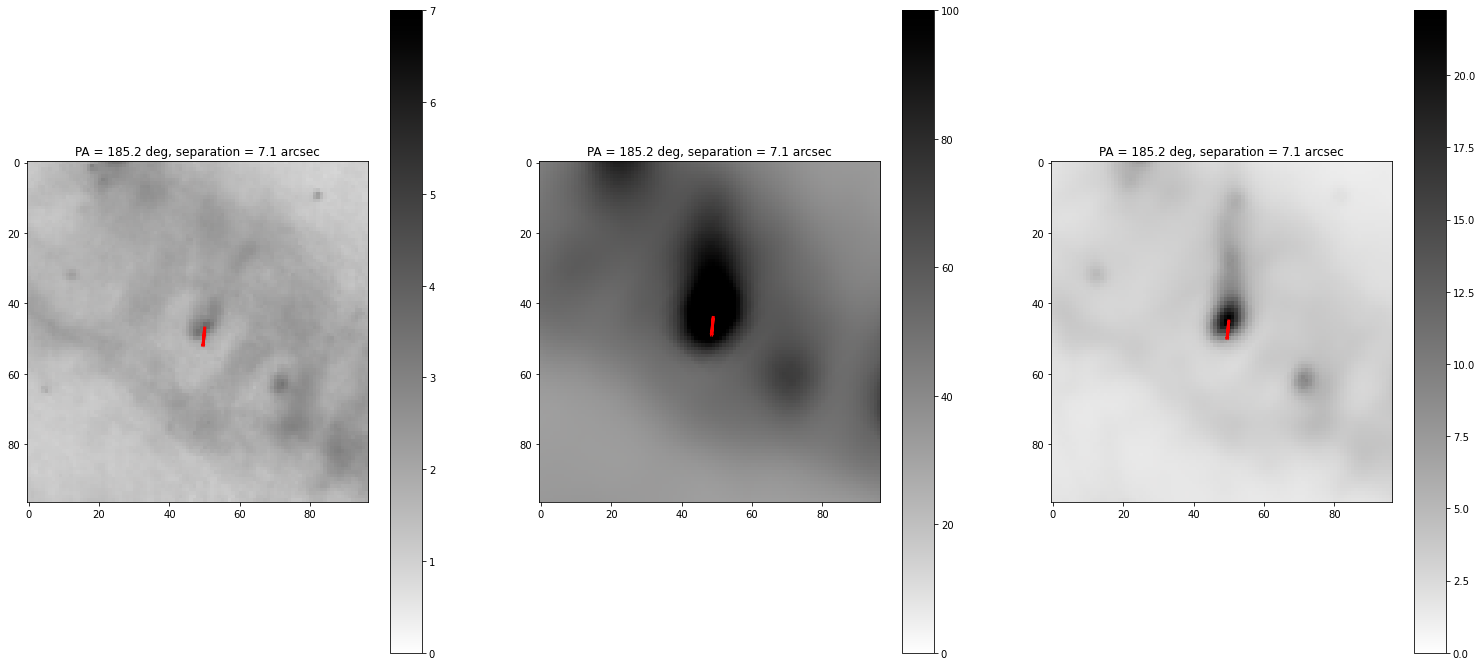

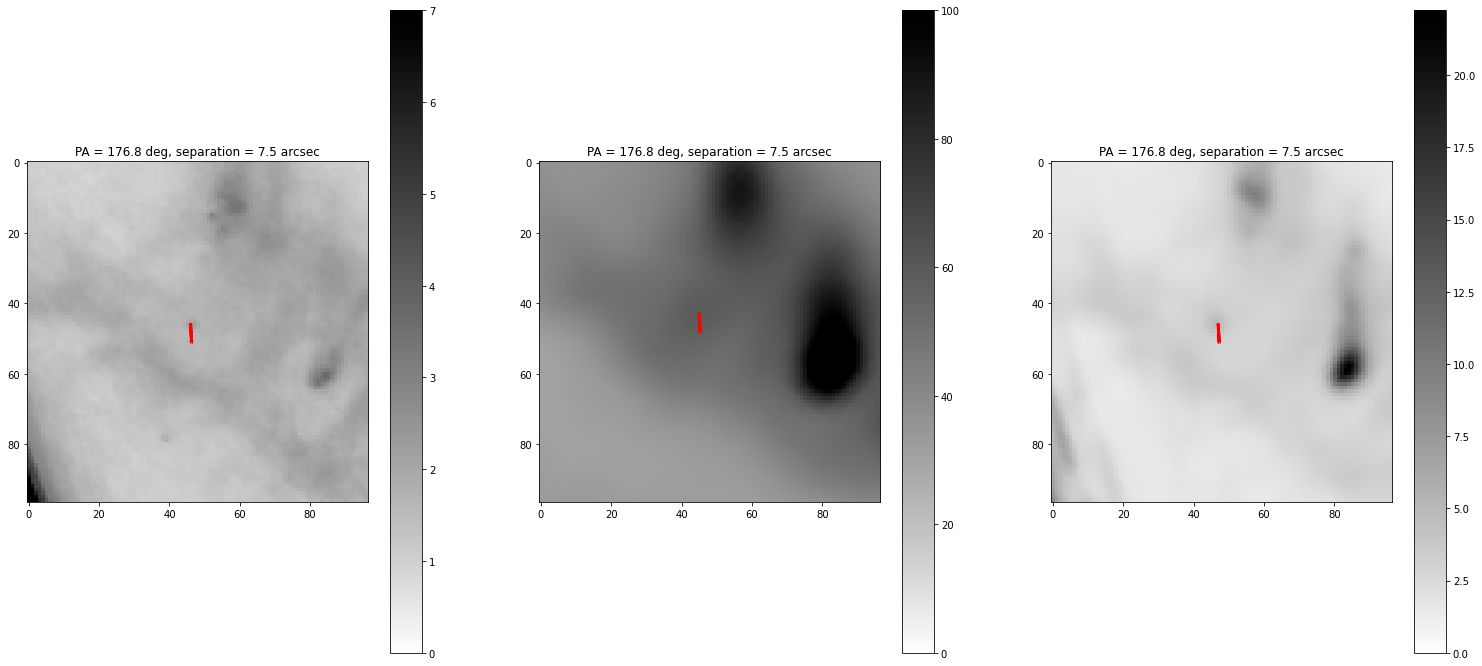

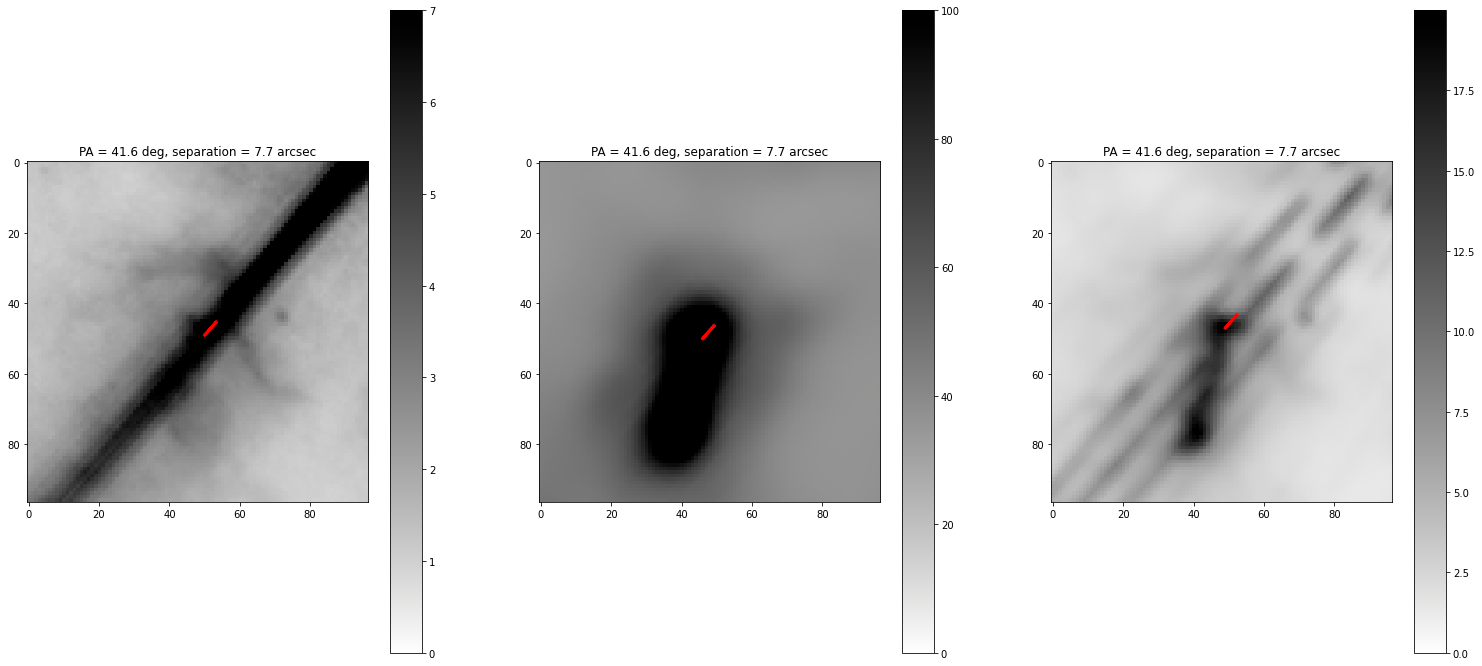

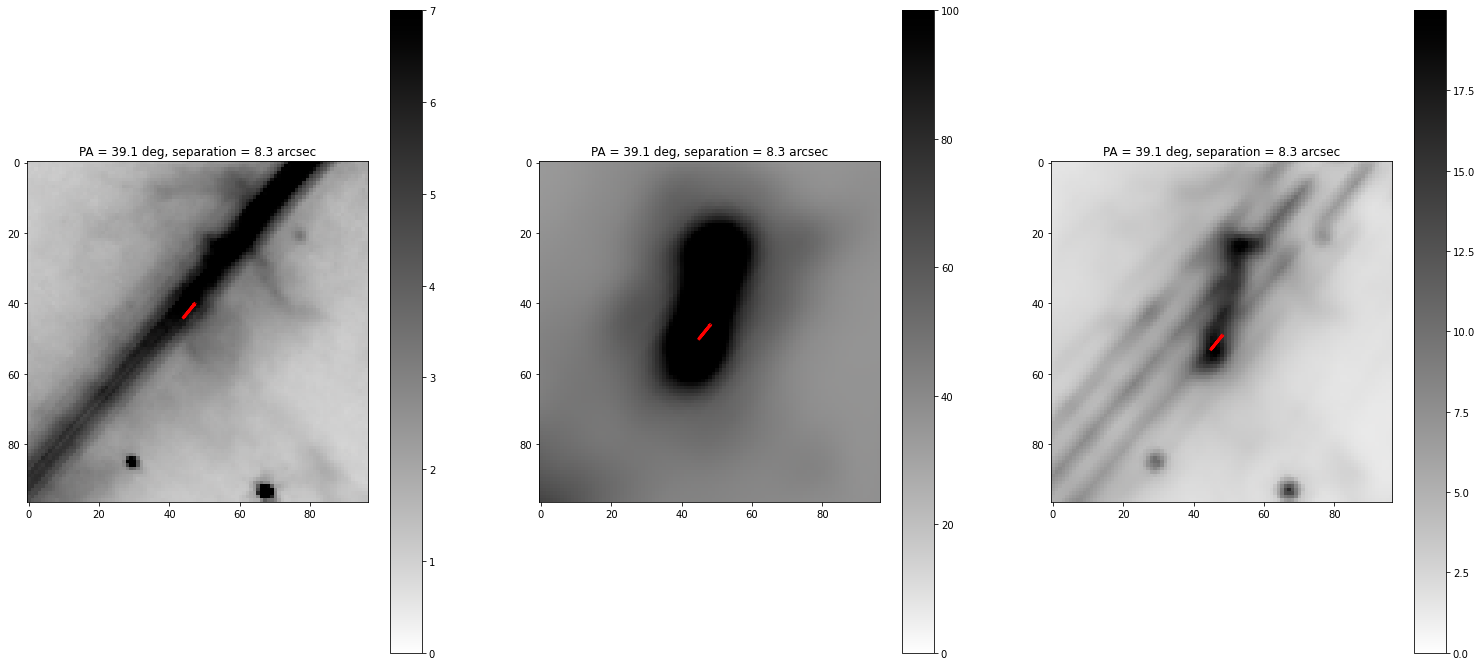

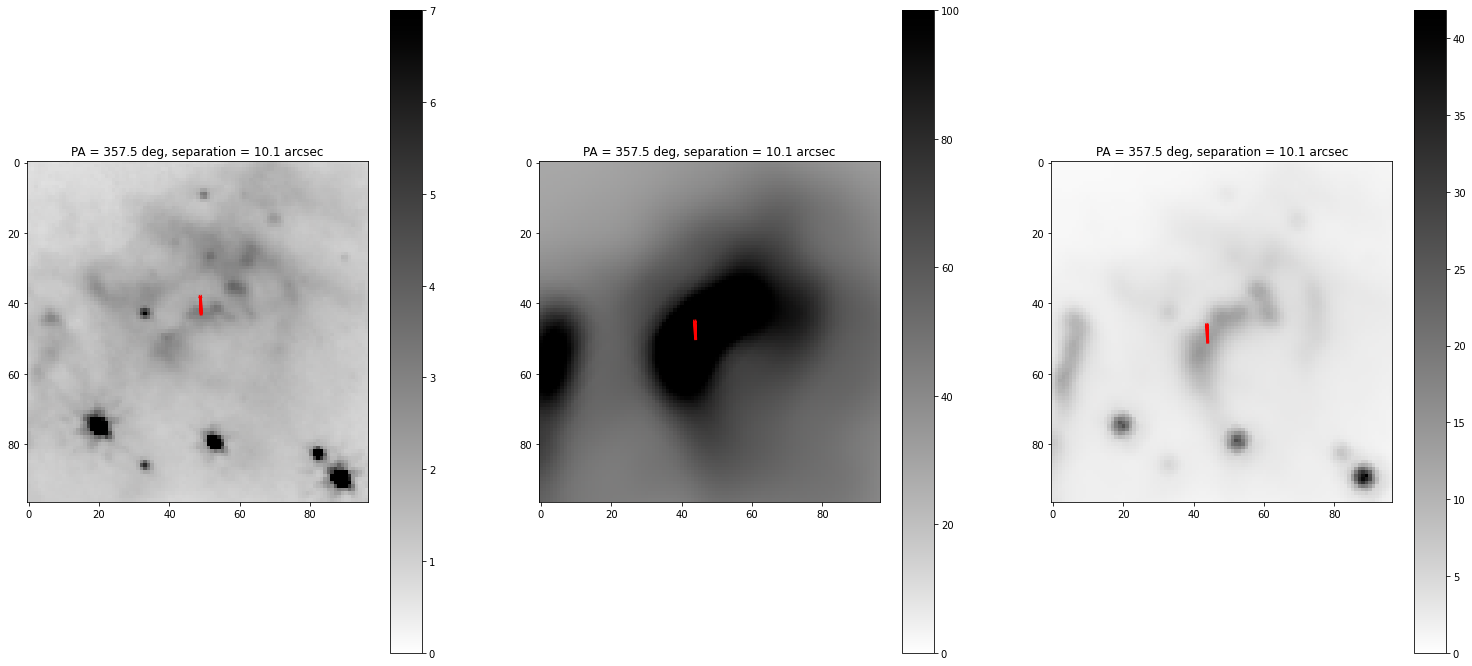

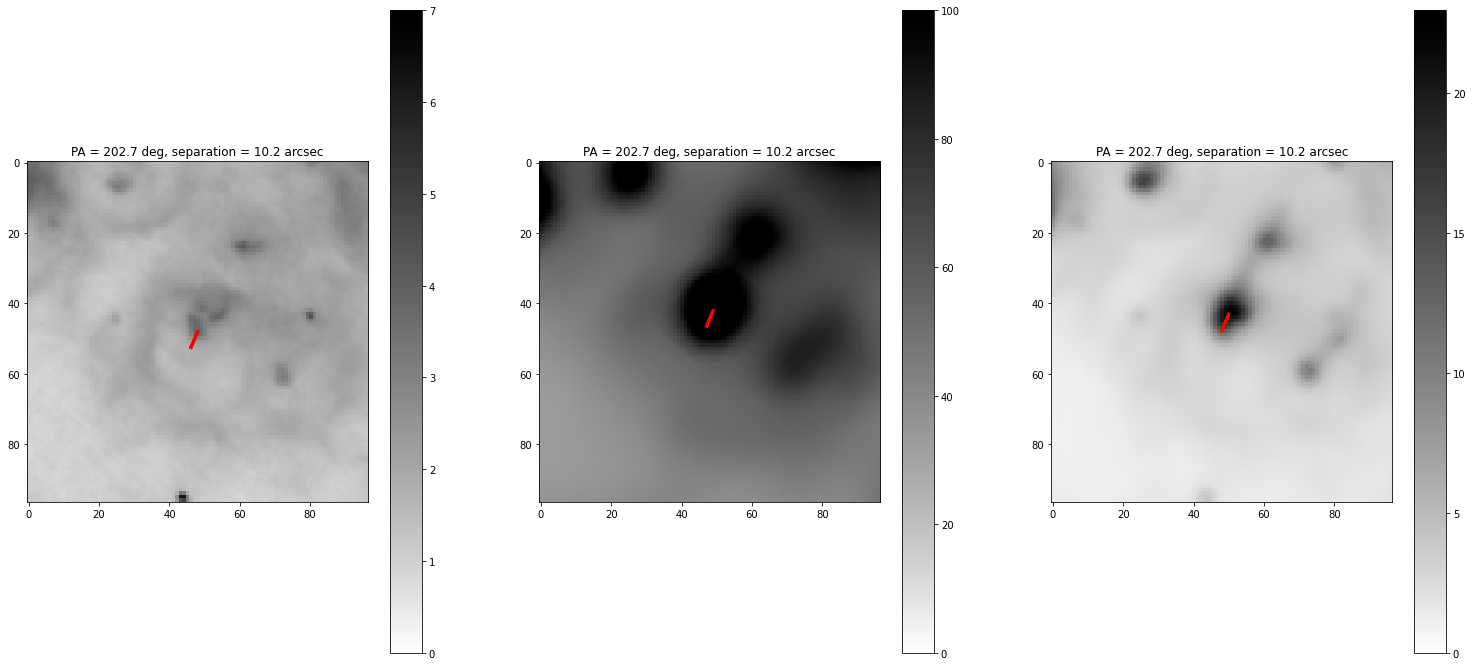

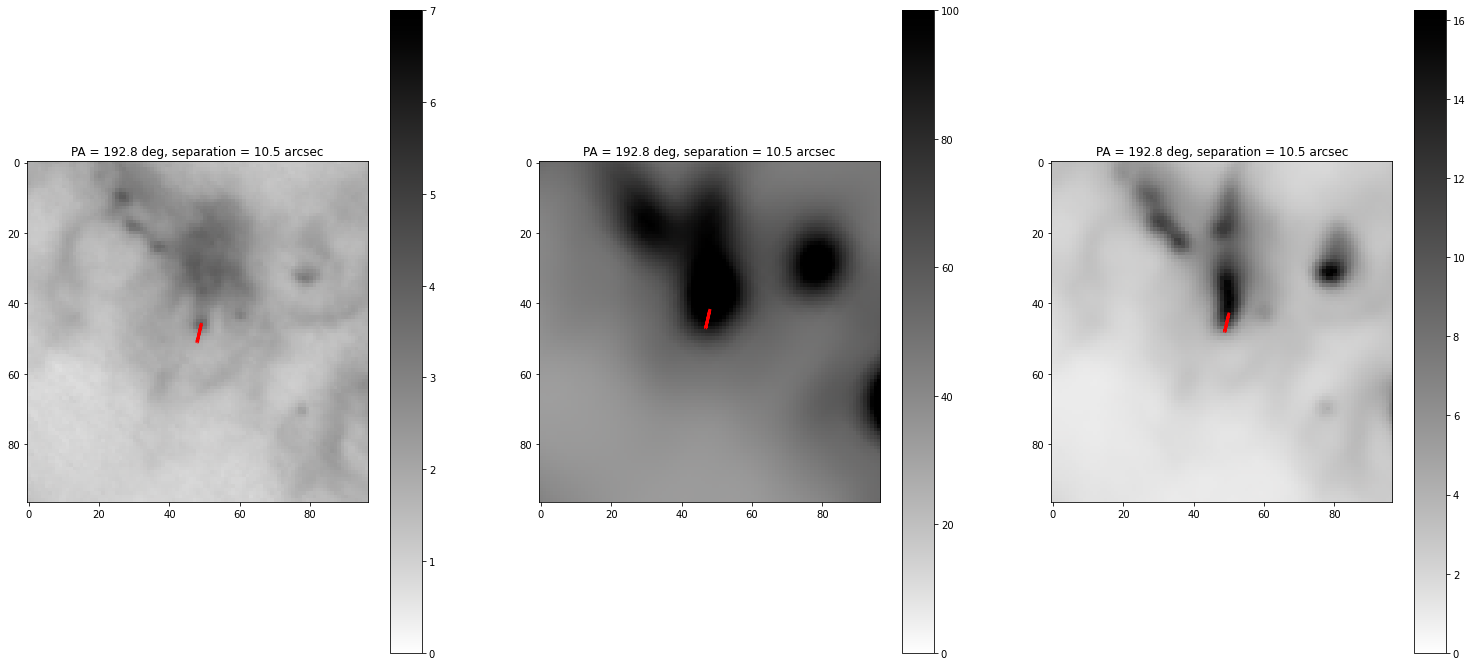

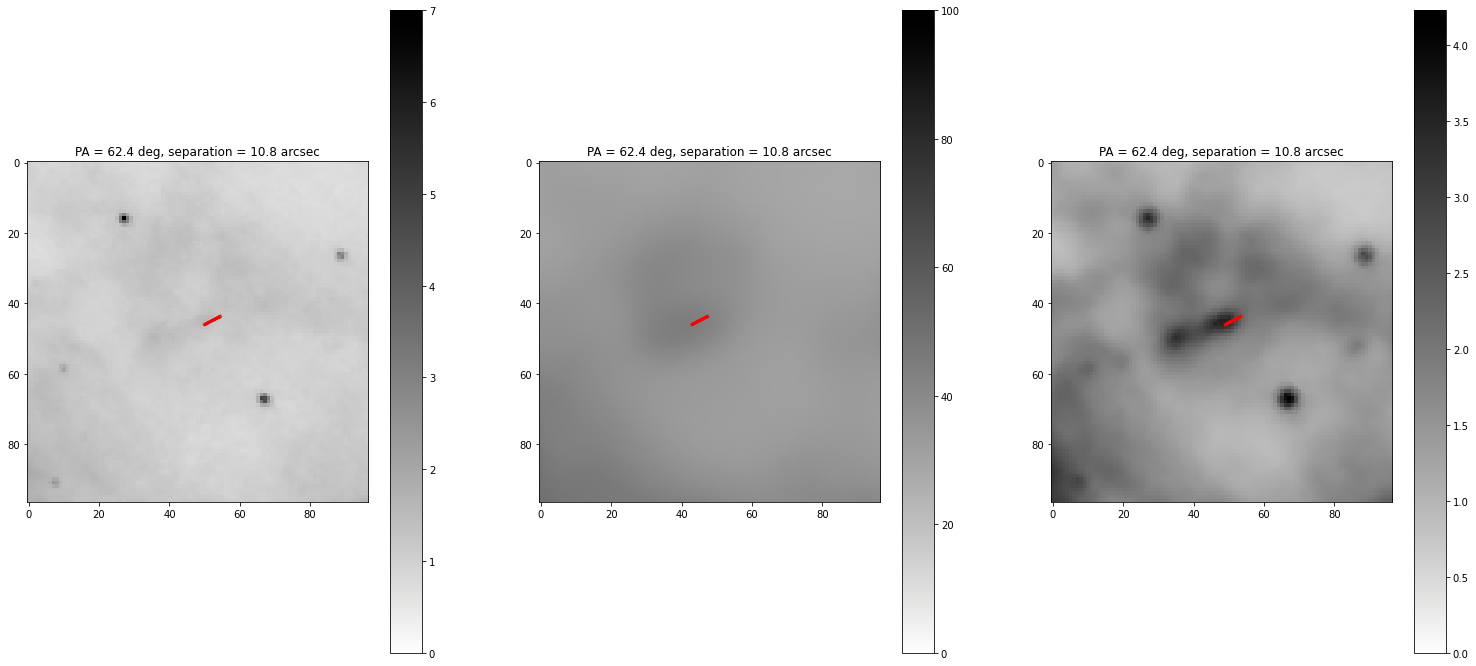

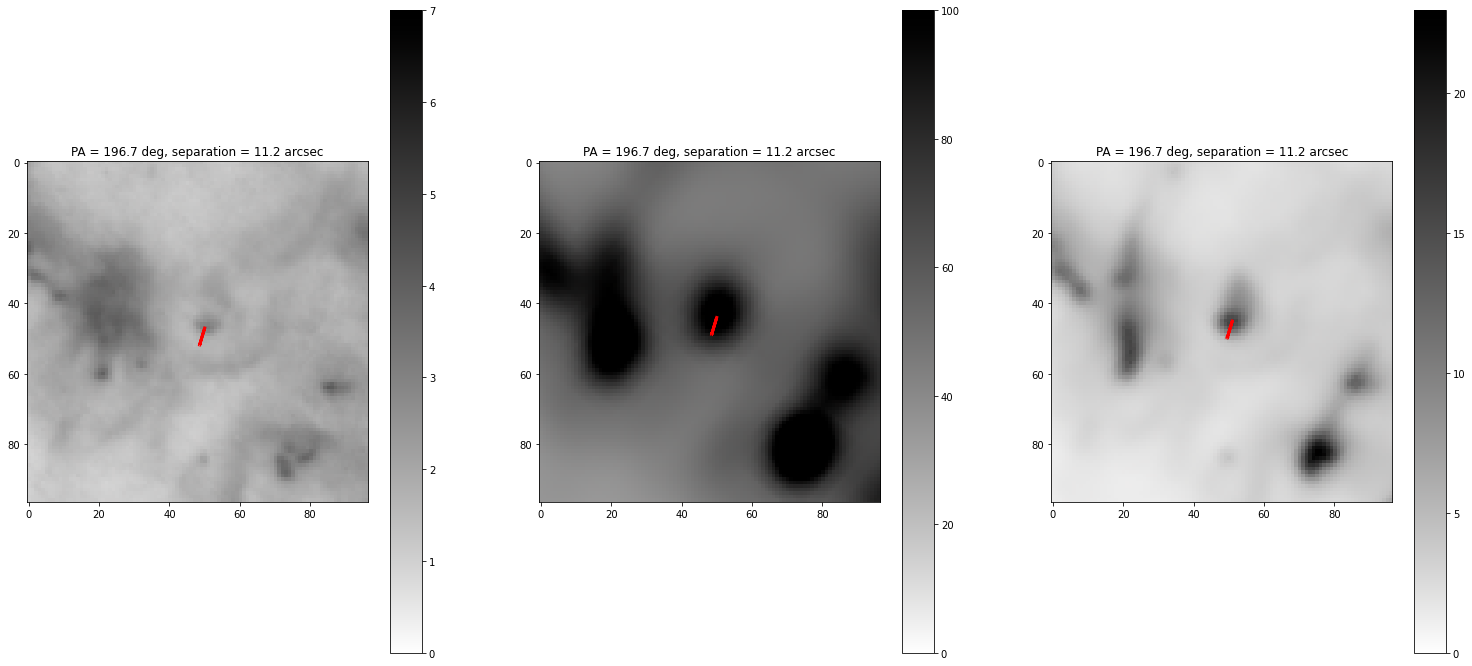

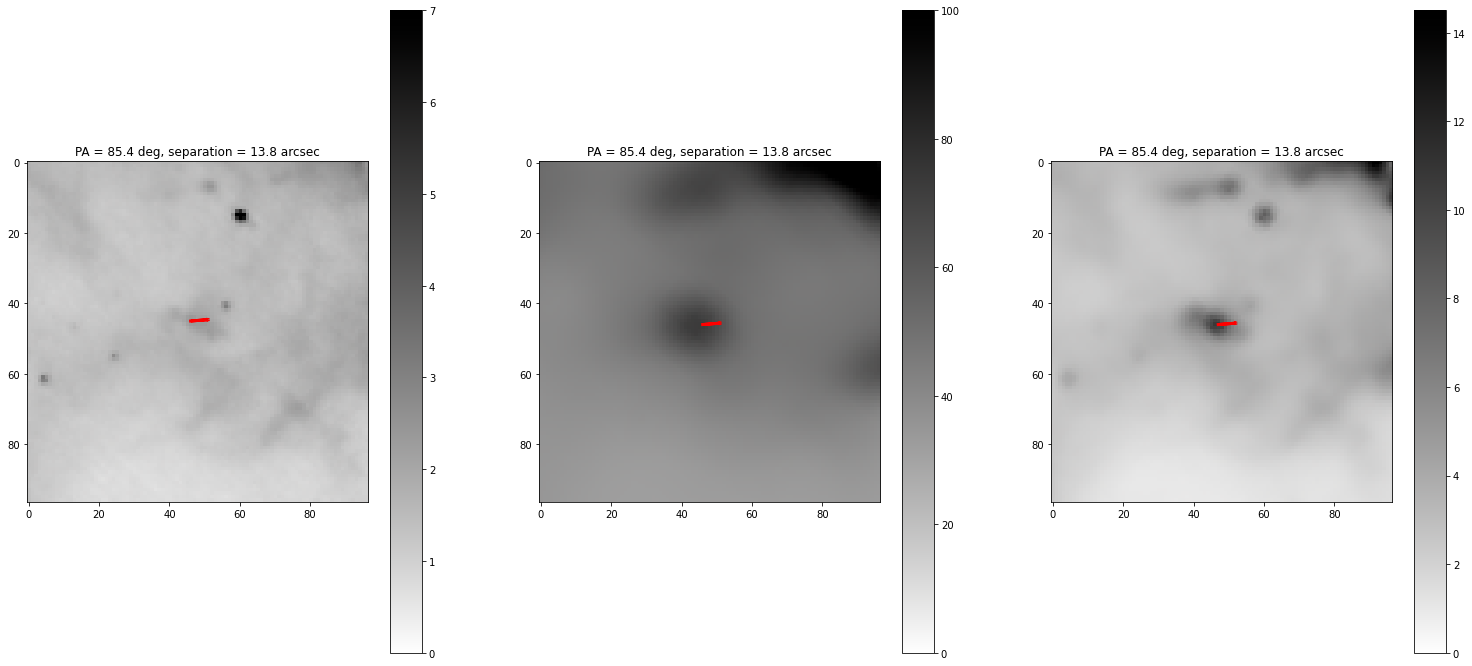

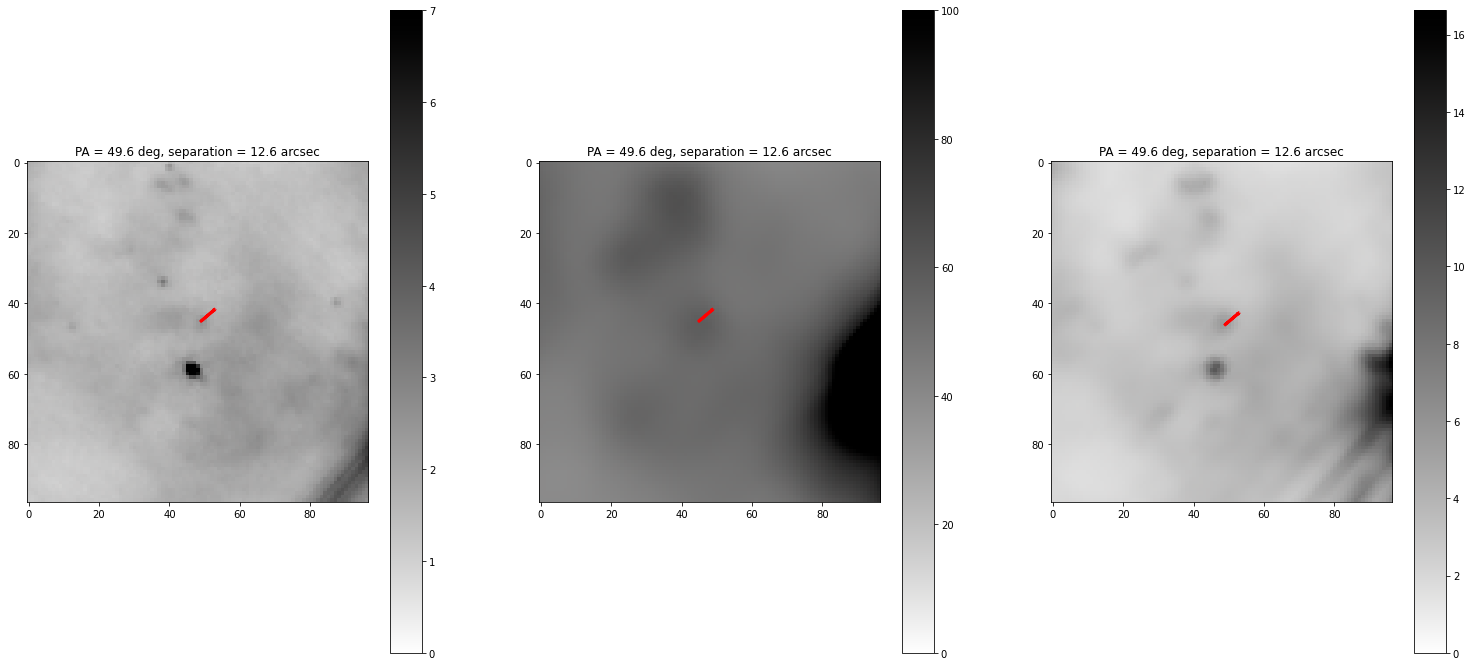

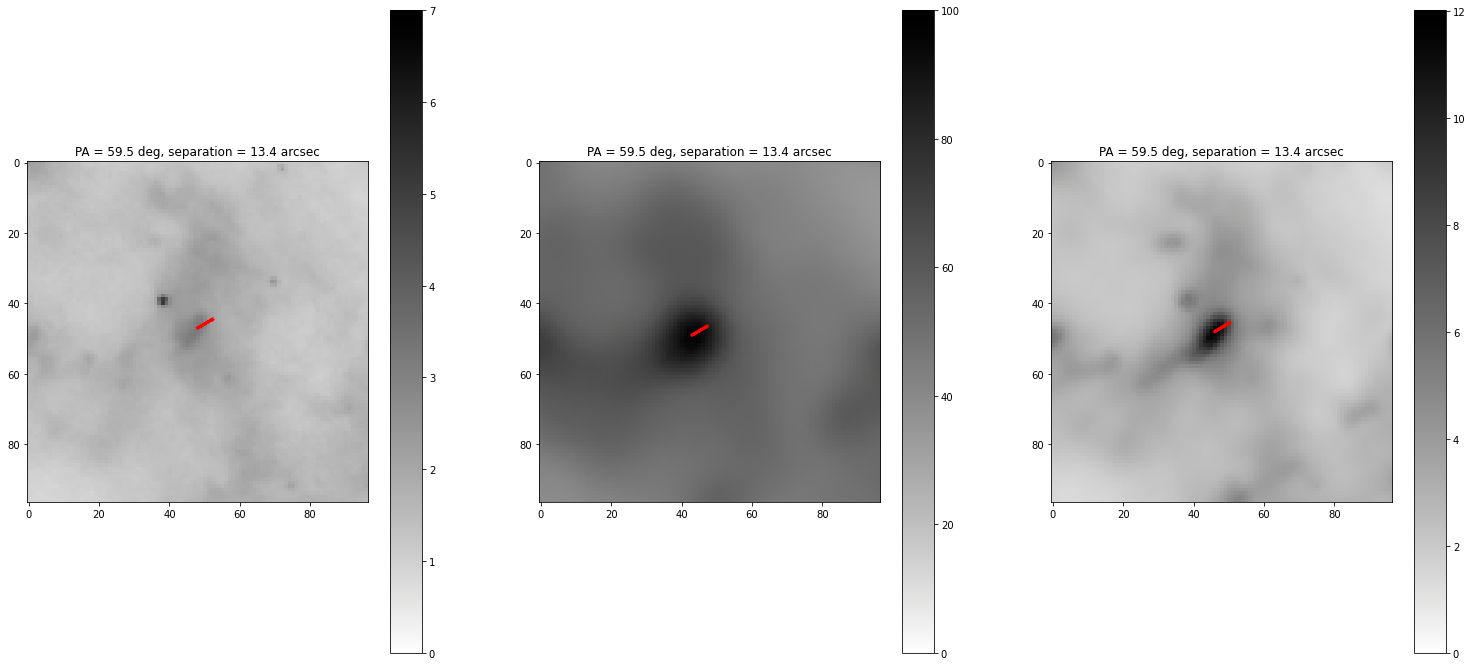

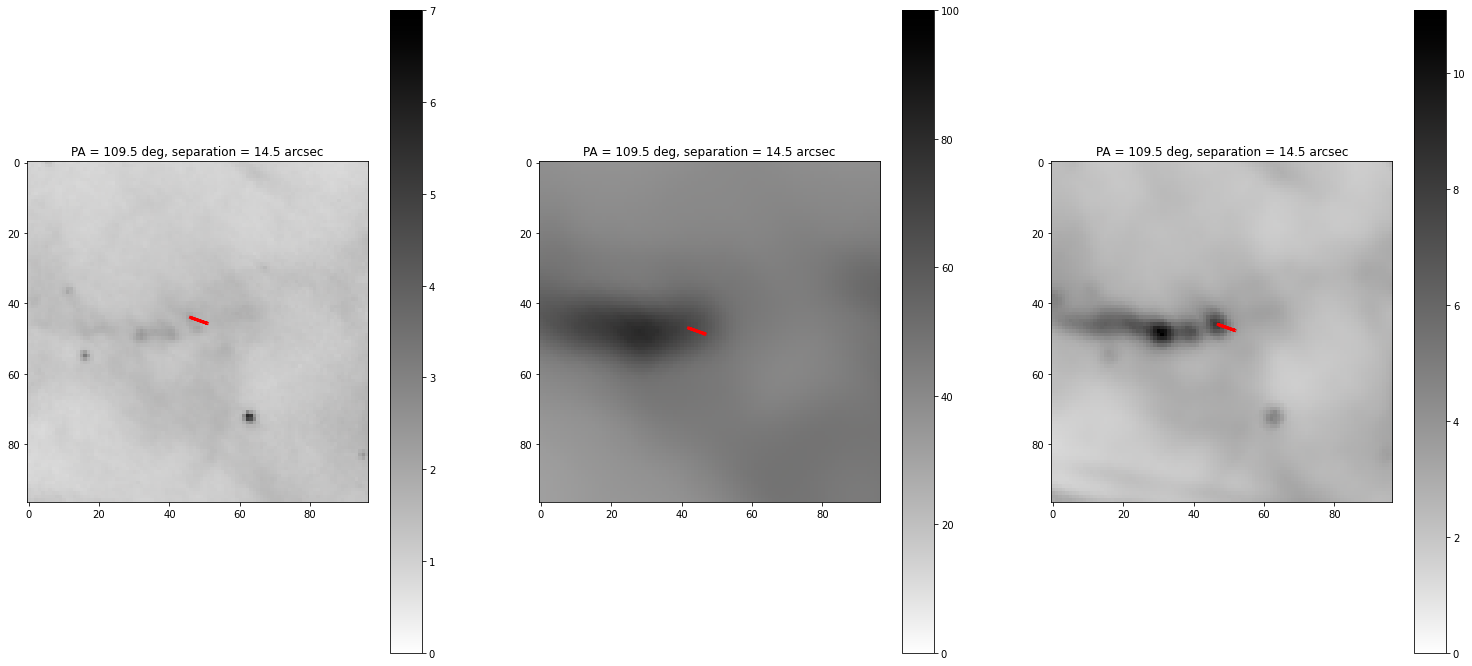

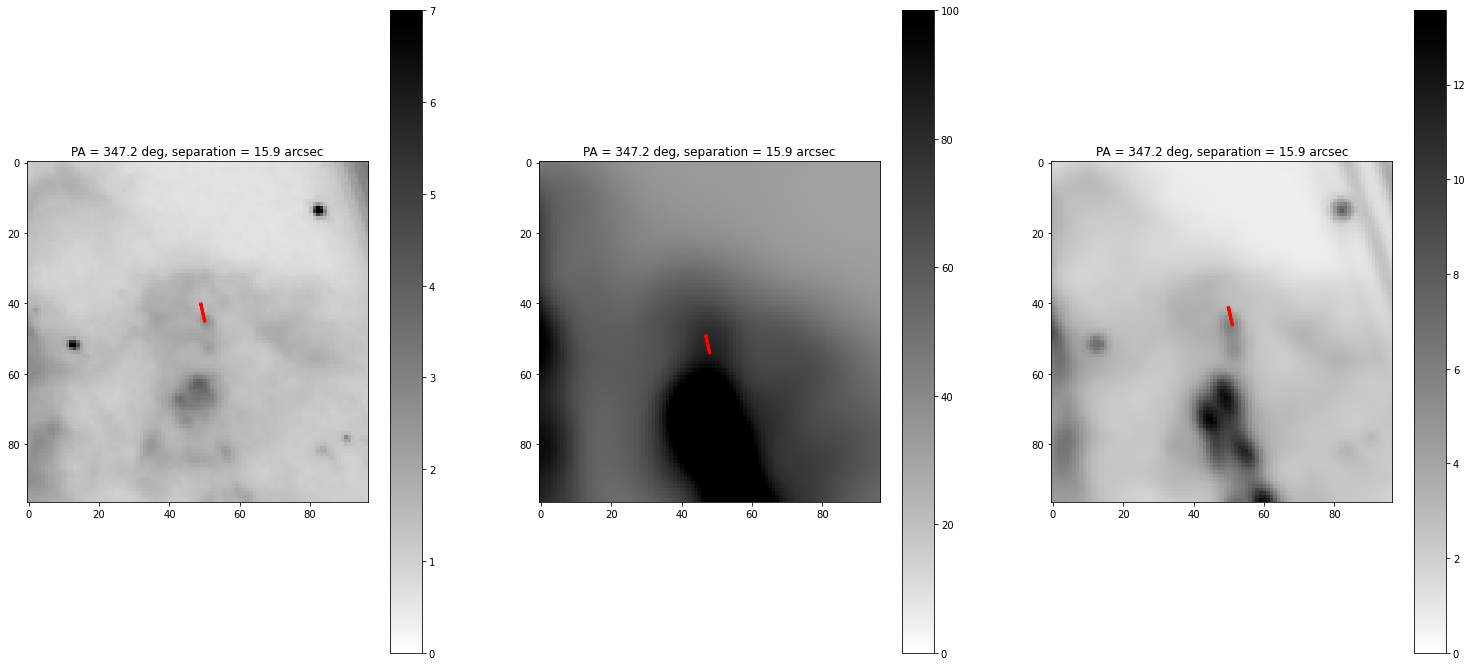

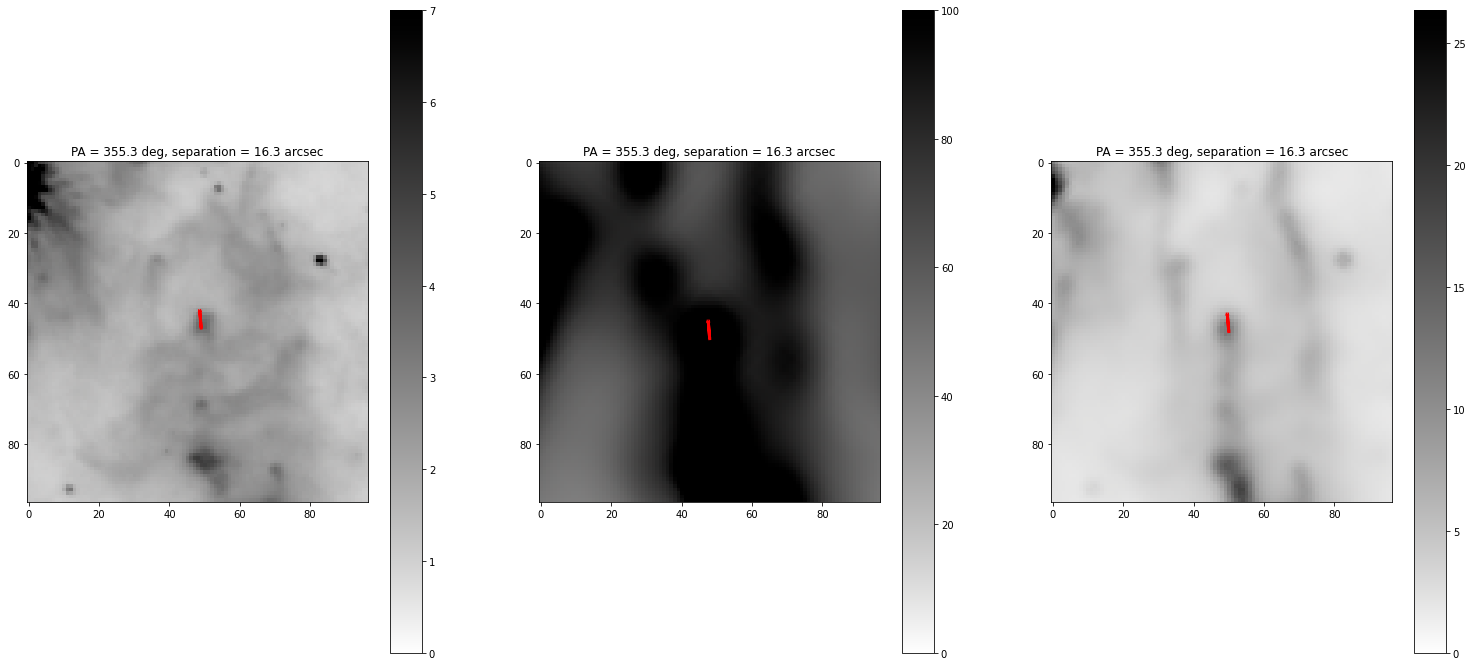

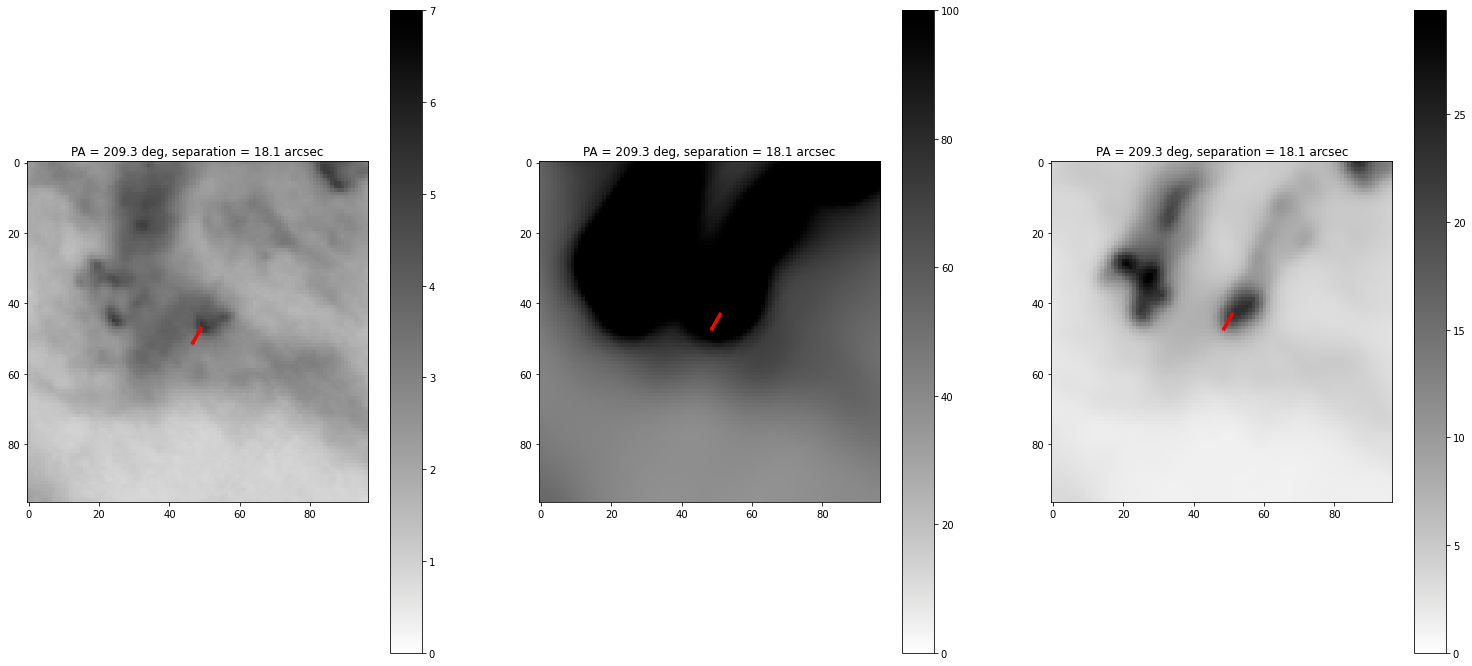

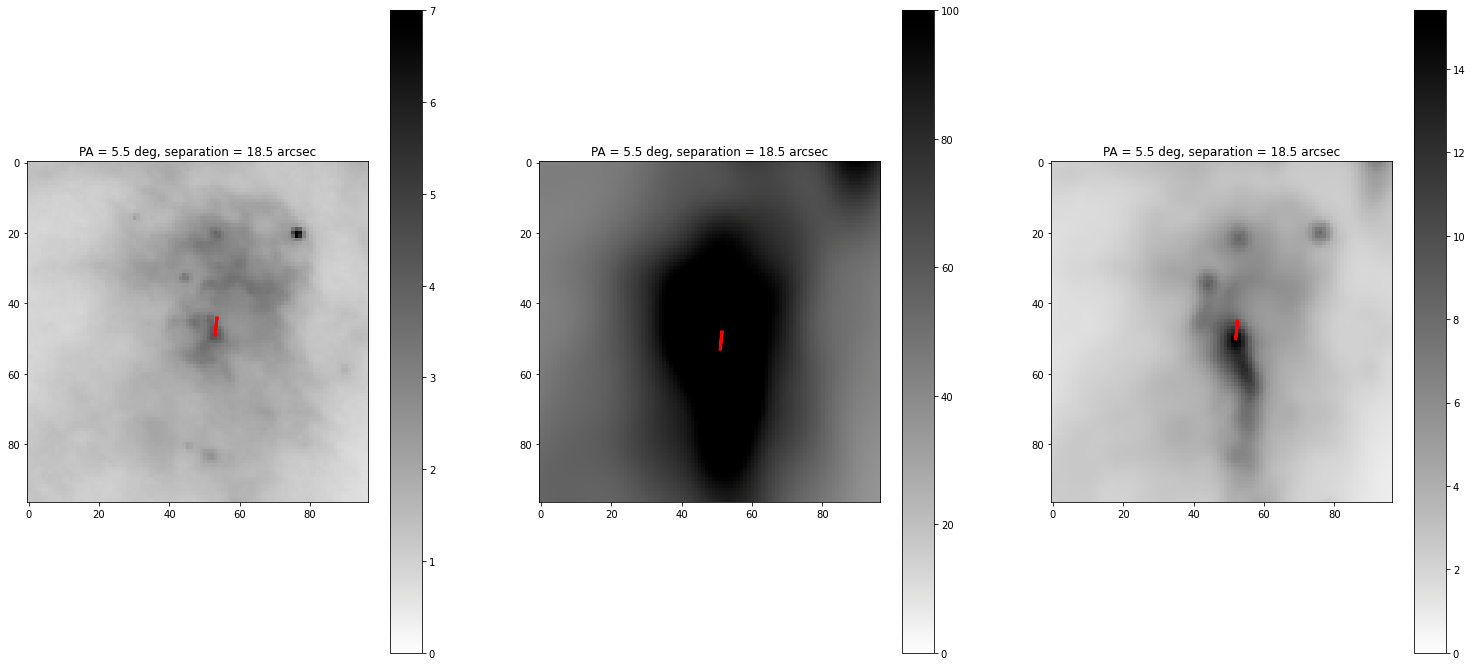

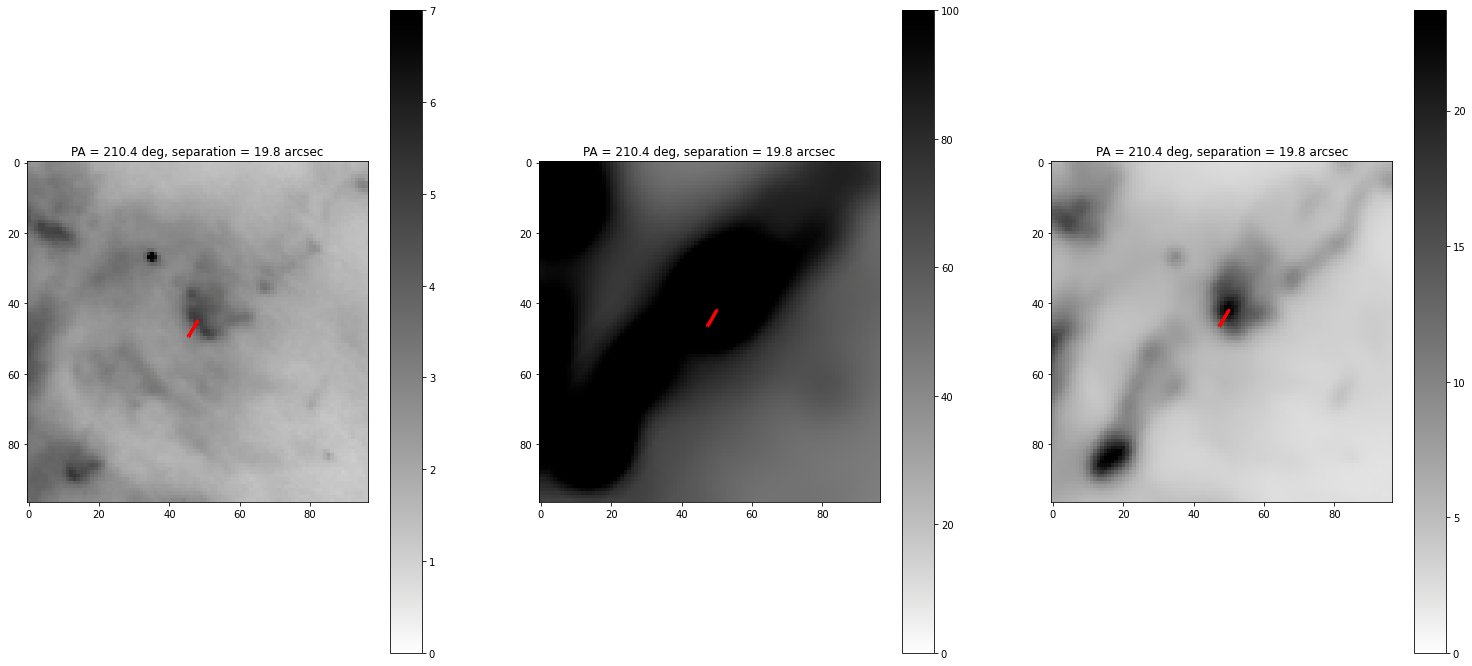

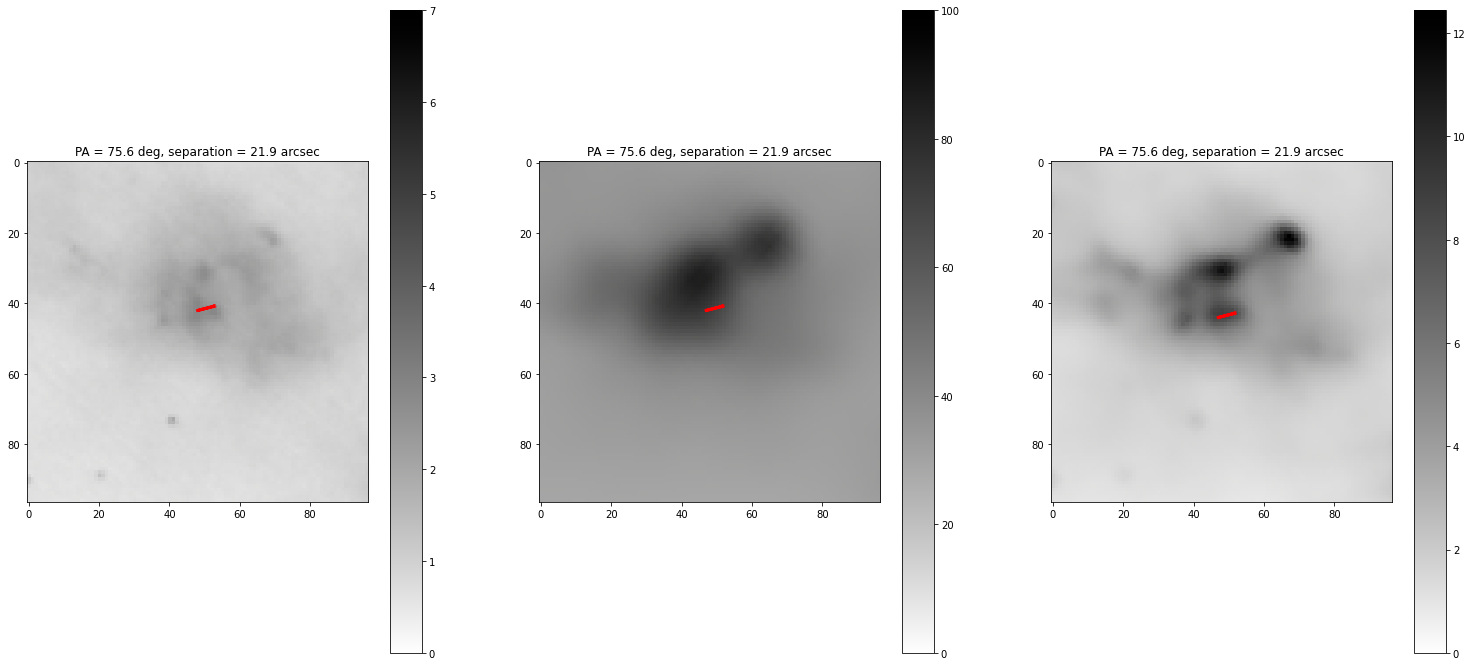

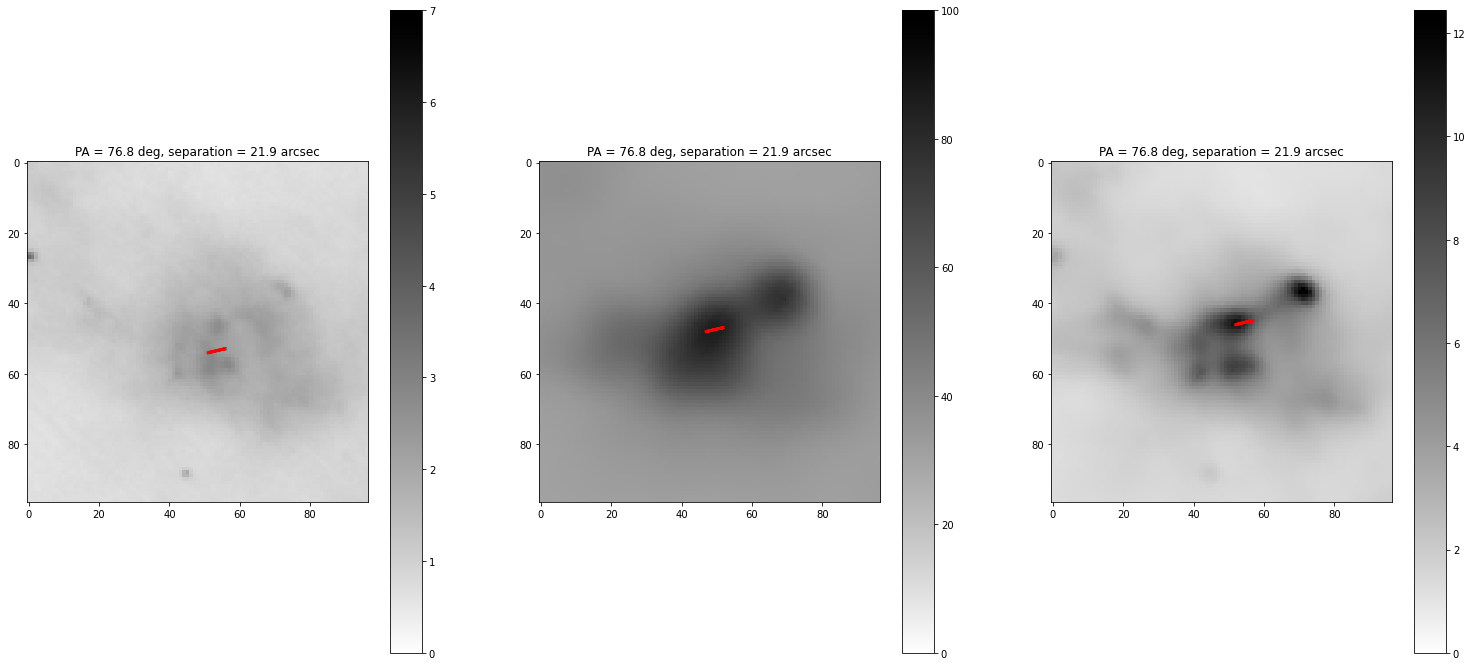

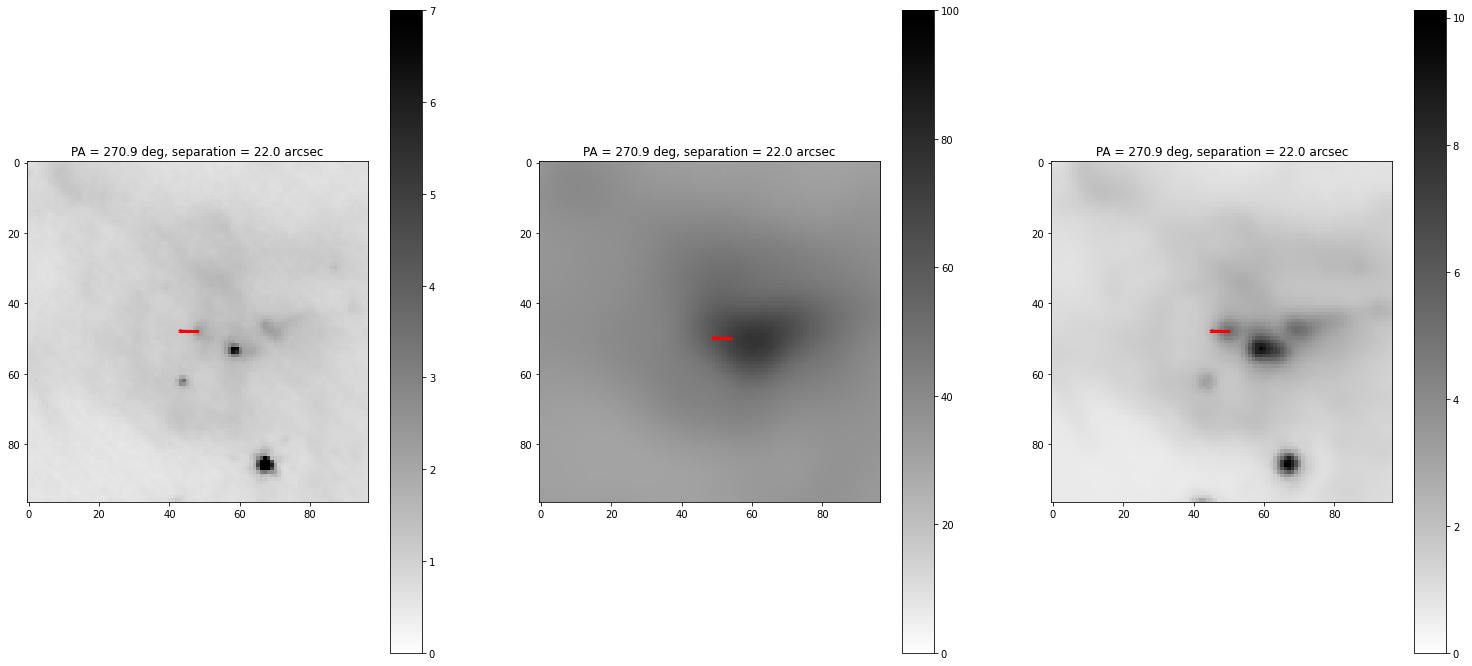

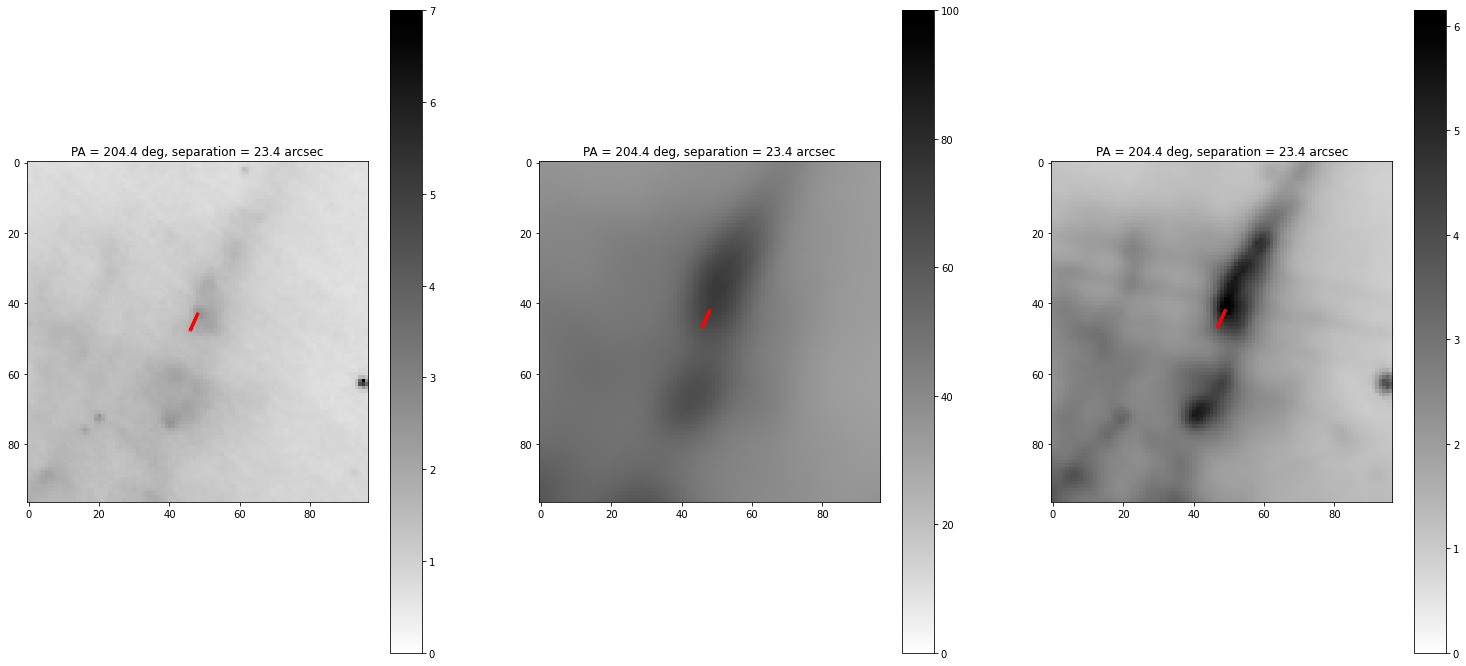

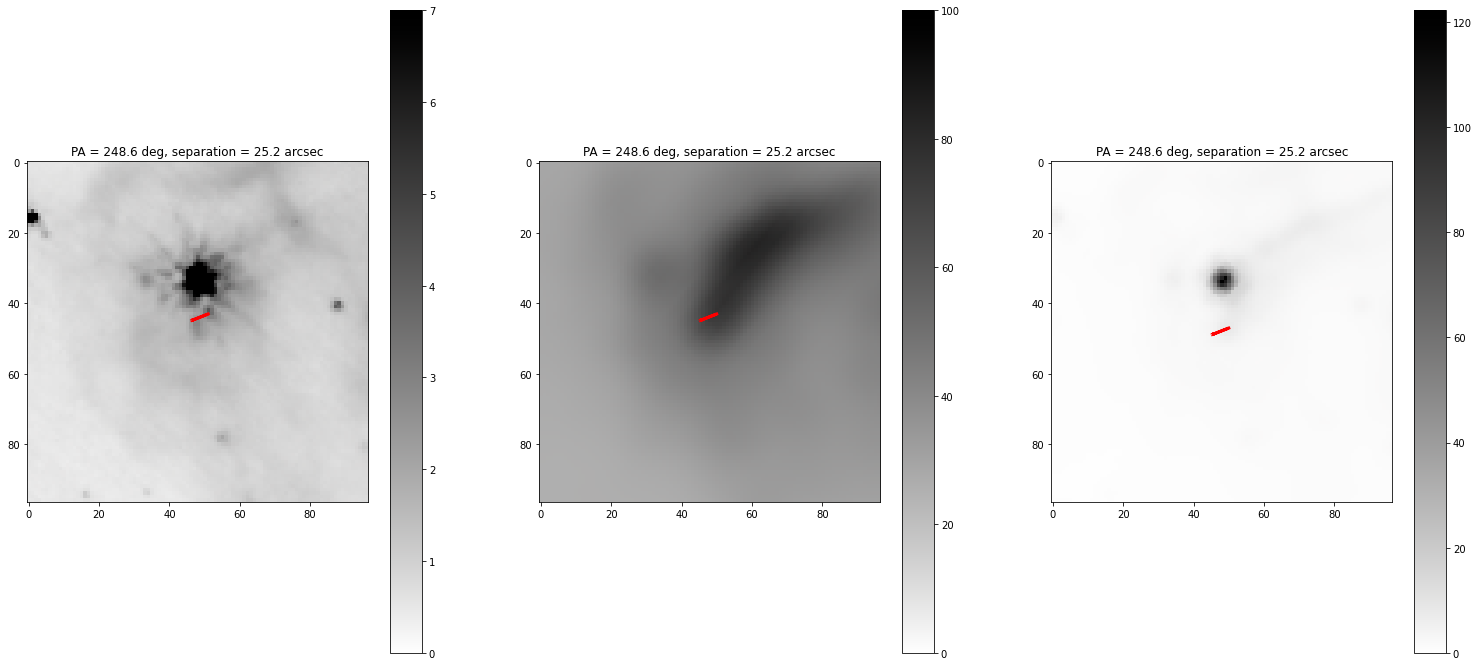

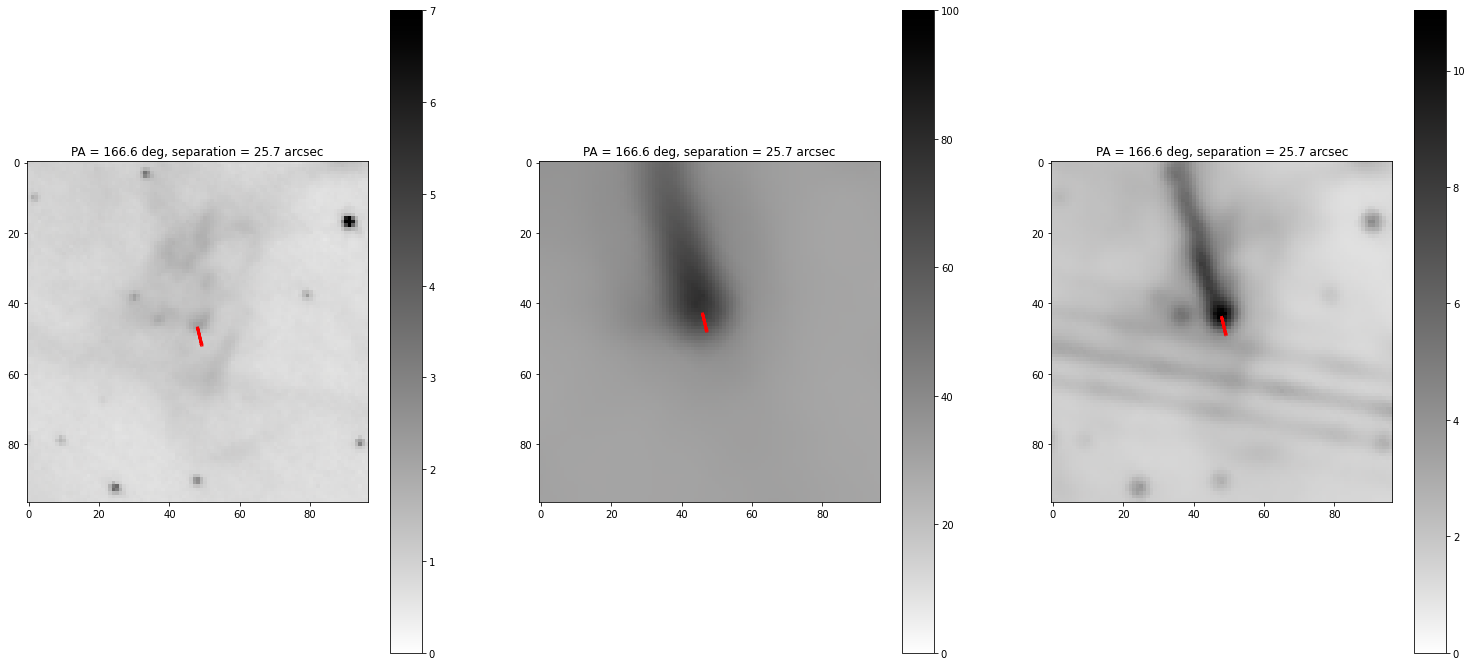

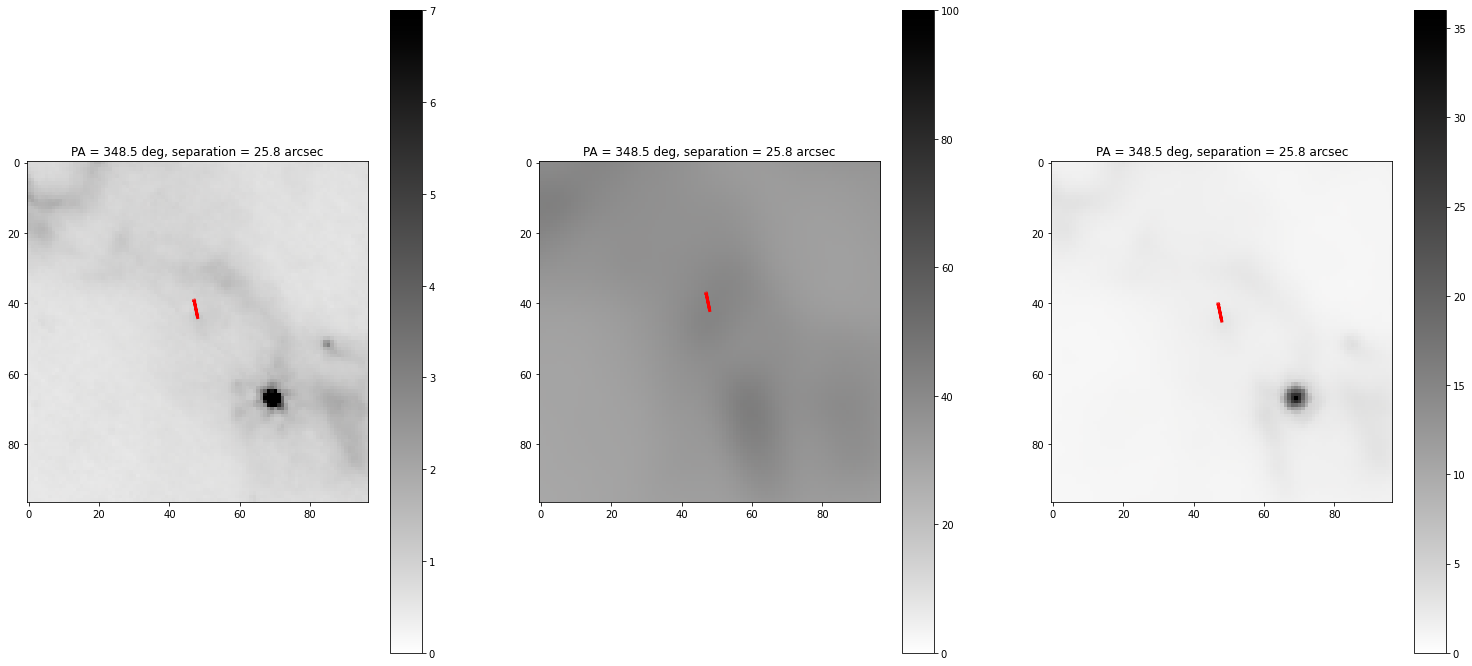

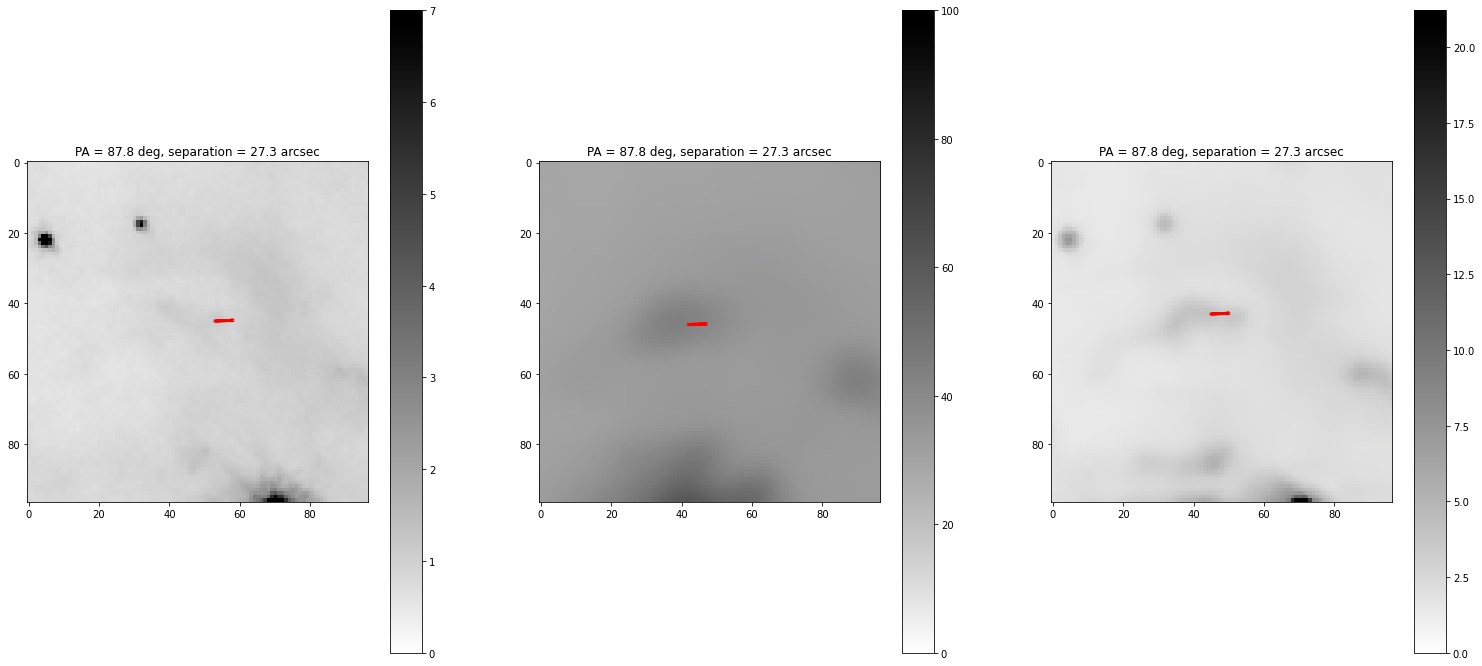

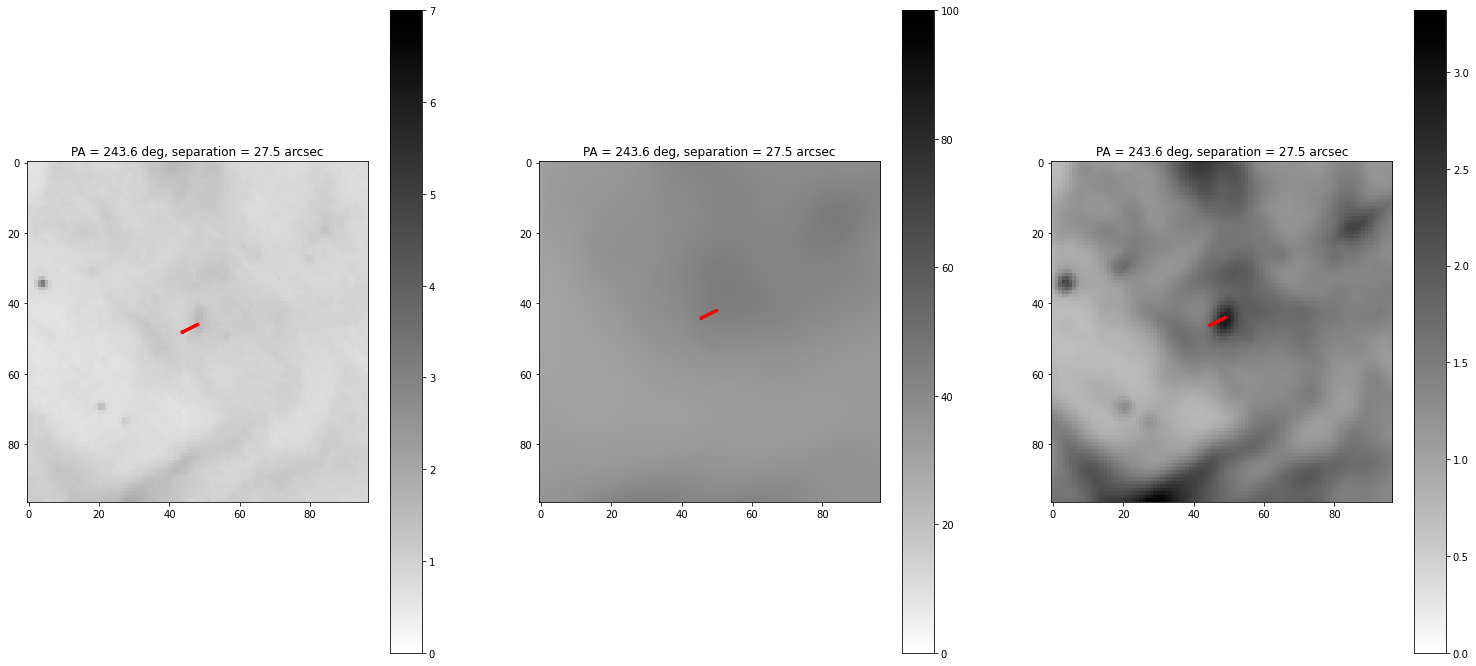

In [27]:
for i in Sel:
    fig =plt.figure(figsize=(26,26))
    '''090'''
    ax = fig.add_subplot(2,3,1)
    cutout = cutouts[i]
    #ax = fig.add_subplot(projection=cutout.wcs)
    im = ax.imshow(
        cutout.image,
        vmin=0.0, 
        vmax=7,
        cmap=cm.neutral_r,
        )
    cb = fig.colorbar(im, ax=ax)
    #ax.imshow(np.where(cutout.mask, np.nan, 1.0), vmin=0, vmax=1, cmap=cm.gem, alpha=0.3)
    y1, x1 = cutout.wcs.world_to_array_index(cutout.barycenter)
    arrow_length = 5.0
    dx, dy = -arrow_length * np.sin(cutout.pa_star), arrow_length * np.cos(cutout.pa_star)
    ax.arrow(x1, y1, dx, dy, color='r', lw=3)
    ax.set_title(f"PA = {cutout.pa_source:.1f}, separation = {cutout.sep:.1f}")
    
    '''1130'''
    ax = fig.add_subplot(2,3,2)
    cutout = cutouts_c[i]
    #ax = fig.add_subplot(projection=cutout.wcs)
    im = ax.imshow(
        cutout.image,
        vmin=0.0, 
        vmax=100,
        cmap=cm.neutral_r,
        )
    cb = fig.colorbar(im, ax=ax)
    #ax.imshow(np.where(cutout.mask, np.nan, 1.0), vmin=0, vmax=1, cmap=cm.gem, alpha=0.3)
    y1, x1 = cutout.wcs.world_to_array_index(cutout.barycenter)
    arrow_length = 5.0
    dx, dy = -arrow_length * np.sin(cutout.pa_star), arrow_length * np.cos(cutout.pa_star)
    ax.arrow(x1, y1, dx, dy, color='r', lw=3)
    ax.set_title(f"PA = {cutout.pa_source:.1f}, separation = {cutout.sep:.1f}")
    
    '''335'''
    ax = fig.add_subplot(2,3,3)
    cutout = cutouts_3[i]
    #ax = fig.add_subplot(projection=cutout.wcs)
    im = ax.imshow(
        cutout.image,
        vmin=0.0, 
        cmap=cm.neutral_r,
        )
    cb = fig.colorbar(im, ax=ax)
    #ax.imshow(np.where(cutout.mask, np.nan, 1.0), vmin=0, vmax=1, cmap=cm.gem, alpha=0.3)
    y1, x1 = cutout.wcs.world_to_array_index(cutout.barycenter)
    arrow_length = 5.0
    dx, dy = -arrow_length * np.sin(cutout.pa_star), arrow_length * np.cos(cutout.pa_star)
    ax.arrow(x1, y1, dx, dy, color='r', lw=3)
    ax.set_title(f"PA = {cutout.pa_source:.1f}, separation = {cutout.sep:.1f}")
    
    fig.savefig(rf'globule_{i}.pdf')